Connected to venv (Python 3.13.5)

In [29]:
import sys

# Add ODE_numerical_solver module to PATH variable
sys.path.insert(
    1,
    "/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/src/data"
)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import scienceplots
from tqdm import tqdm
from scipy.stats import qmc, skew, kurtosis
from torchinfo import summary
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from pyhessian import hessian

from utils import set_global_seed
from pinn_architecture import PINN
from loss_functions import *
from global_constants import *
from ODE_numerical_solver import swing_ODEs_solver

# The cell below requires editing the parameter being varied

In [30]:
# Define and fix seed
SEED: int = 20
set_global_seed(SEED)

# Specify the parameter to be varied and it's symbol
VARYING_PARAM: str = "damping"
VARYING_PARAM_NOTATION: str = "d"

# Boolean constant only adds title on subplots on the top most row (first random seed 0)
TOP_PLOT: bool = True

# Specify the range of parameter values
PARAM_LIST: list[float] = [0.0015, 0.015, 0.15, 1.5]
# DAMPING: torch.Tensor = torch.tensor(data=[[0.15]])
INERTIA: torch.Tensor = torch.tensor(data=[[0.25]])

# Path to save images and flag
PATH_TO_IM_DIR: str = "/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick"\
                        f"/dissertation_code/data/visualisations/loss_landscapes/{VARYING_PARAM}/"

SAVE: bool = False

In [31]:
# Config matplotlib and define plot constants
plt.style.use("science")
plt.rcParams["text.usetex"] = True

CMAP: str = "seismic"  # Color map for the visualisations

# Move tensors and models to GPU
DEVICE: str = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print the training loss every specified number of epochs
PRINT_TRAINING_LOSS_EVERY_EPOCH: int = 100

# Define the parameters for the ODE numerical solution
INITIAL_STATE: torch.tensor = torch.tensor(
    data=np.array([0.1, 0.1]), dtype=torch.float64
).to(device=DEVICE)

# Boolean constant for whether or not PI controllers included
CONTROLLERS: bool = False

# PINN Hyperparameter constants
LEARNING_RATE: float = 0.01
# SCHEDULER_STEP_SIZE: int = 200
PATIENCE: int = 10
SCHEDULER_FACTOR: float = 0.9
HISTORY: int = 50
EPOCHS: int = 5_000
N_C: int = 1_000  # Number of collocation points

# PINN soft regularisation weights in the loss function
PHYSICS_WEIGHT: float = 1.0
IC_WEIGHT: float = 1.0

# Specify activation function
ACTIVATION: str = "tanh"

# Obtain collocation points sampled via LHS of size N_C
LHC = qmc.LatinHypercube(d=1)
collocation_points = LHC.random(n=N_C)
collocation_points = qmc.scale(
    collocation_points, T0, FINALTIME
).flatten()  # Scale from a unit interval [0,1] (default) to [t0,T]

collocation_points: torch.tensor = torch.tensor(
    data=collocation_points[:, None].astype(np.float32), requires_grad=True
).to(device=DEVICE)

## Obtain a numerical solution to obtain an array of indices to index on

In [32]:
numerical_solutions_exact = []
numerical_solutions_noisy = []
numerical_domain = None

# Use TIMESTEP_FLOAT instead of TIMESTEP tensor due to floating-point errors
TIMESTEP_FLOAT = 0.1

# Define number of total data points from numerical solution, N
N: int = int((FINALTIME - T0)/(TIMESTEP_FLOAT) + 1)

for param in PARAM_LIST:
    solution, noisy_solution, numerical_times = swing_ODEs_solver(
    initial_time=T0,
    initial_state=INITIAL_STATE.detach().numpy(),
    final_time=FINALTIME,
    timestep=TIMESTEP_FLOAT,
    inertia=INERTIA.item(),
    damping=param,
    mechanical_power=MECHANICAL_POWER.item(),
    voltage_magnitude=VOLTAGE.item(),
    include_controllers=False,
    voltages=np.array([VOLTAGES.item()]),
    phase_angles=np.array([PHASE_ANGLES.item()]),
    susceptances=np.array([SUSCEPTANCES.item()]),
    file_name="test_run",
    save_output_to_file=False,
    controller_proportional=0.05,
    controller_integral=0.1,
    )

    if numerical_domain is None:
        numerical_domain = numerical_times

    numerical_solutions_exact.append(solution)
    numerical_solutions_noisy.append(noisy_solution)

numerical_solutions_exact = np.array(numerical_solutions_exact).reshape(2, N, len(PARAM_LIST))
numerical_solutions_noisy = np.array(numerical_solutions_noisy).reshape(2, N, len(PARAM_LIST))

numerical_solutions_exact_tensor = torch.tensor(numerical_solutions_exact)
numerical_solutions_noisy_tensor = torch.tensor(numerical_solutions_noisy)
times_tensor = torch.tensor(numerical_domain[:, None].astype(np.float32), requires_grad=True)

# Obtain a random array of index to index the numerical solution on to obtain training data
# for vanilla NN
rand_index = np.random.randint(low=1, high=numerical_domain.shape[0]-1, size=int(np.ceil(numerical_domain.shape[0]*0.1)))
rand_index = np.append(rand_index, 0)
int(np.ceil(numerical_domain.shape[0]*0.1))

21

In [33]:
# Define subspace mesh
LB: int = -10
NUM_VERTICES: int = 40
INCREMENT: float = -2*LB / NUM_VERTICES

alpha_1: torch.Tensor = torch.arange(start=LB, end=-LB+INCREMENT, step=INCREMENT)
alpha_2: torch.Tensor = torch.arange(start=LB, end=-LB+INCREMENT, step=INCREMENT)
ALPHA_1, ALPHA_2 = np.meshgrid(alpha_1.numpy(), alpha_2.numpy())

# Obtain the dimensionality of the parameter space
TOTAL_NUM_PARAMS: int = summary(model=PINN(activation=ACTIVATION).to(device=DEVICE)).total_params

# Sample Gaussian random direction vectors as in Li et al. (2018)
direction_vec_1: torch.Tensor = torch.randn(TOTAL_NUM_PARAMS)

# Make into a unit vectors
direction_vec_1 = direction_vec_1 / torch.norm(input=direction_vec_1)

direction_vec_2: torch.Tensor = torch.randn(TOTAL_NUM_PARAMS)

# Use the Gram-Schmidt process to convert linearly independent vectors
# into orthonormal vectors
direction_vec_2 = (
    direction_vec_2 - torch.dot(direction_vec_2, direction_vec_1) * direction_vec_1
)

# Make into unit vector
direction_vec_2 = direction_vec_2 / torch.norm(input=direction_vec_2)

# Test orthogonality and normality
assert torch.dot(direction_vec_1, direction_vec_2) < 1e-8
assert torch.norm(input=direction_vec_1) - 1 < 1e-8
assert torch.norm(input=direction_vec_2) - 1 < 1e-8

# Train the PINNs and obtain the Hessian-based and random direction subspaces
## The cell below requires editing the parameter being varied

In [34]:
# Collect the loss landscapes for both random and Hessian directions for each parameter value
loss_landscapes_random = []
loss_landscapes_hessian = []

# Collect all trained PINN models for each parameter
pinn_models = []

# Collect training losses across each parameter value
training_losses = []

# Iterate over all parameter values
for index, param in enumerate(PARAM_LIST):

    print(f"Param value {index+1}")
    print("----------------------\n")

    ######################################################
    # SPECIFY VARIABLE PARAMETER
    ######################################################
    DAMPING: torch.Tensor = torch.tensor(data=[[param]])

    # Obtain numerical solution (RK45)
    solution, _, times = swing_ODEs_solver(
    initial_time=0,
    initial_state=INITIAL_STATE.detach().numpy(),
    final_time=20.0,
    timestep=0.1,
    inertia=0.25,
    damping=param,
    mechanical_power=0.13,
    voltage_magnitude=1.0,
    include_controllers=False,
    voltages=np.array([1.0]),
    phase_angles=np.array([0.0]),
    susceptances=np.array([0.2]),
    file_name="test_run",
    save_output_to_file=False,
    controller_proportional=0.05,
    controller_integral=0.1,
    )

    # Convert into Tensors
    times = np.array([times[id] for id in rand_index]).flatten()
    times = torch.tensor(
        data=times.astype(np.float32)[:, None], requires_grad=True
    ).to(device=DEVICE)

    # NB: Training data is only the phase angle
    training_data = np.array([solution[0,:][id] for id in rand_index]).flatten()
    training_data = torch.tensor(
        data=training_data.astype(np.float32)[:, None]
    ).to(device=DEVICE)

    # Define PINN, optimiser and learning rate scheduler
    pinn = PINN(activation=ACTIVATION).to(device=DEVICE)

    # Instantiate the Adam optimiser and learning rate scheduler
    optimiser = torch.optim.Adam(params=pinn.parameters(), lr=LEARNING_RATE)

    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer=optimiser, patience=PATIENCE, factor=SCHEDULER_FACTOR
    )

    # Define array to collect training loss every epoch
    training_loss = []

    # Perform the training loop using full-batch training
    for epoch in tqdm(range(EPOCHS)):

        # Obtain PINN predictions and it's time derivatives
        phase_angle_pred = pinn.forward(
            data=collocation_points, initial_state=INITIAL_STATE
        )

        angular_frequency_pred = torch.autograd.grad(
            outputs=phase_angle_pred,
            inputs=collocation_points,
            grad_outputs=torch.ones_like(phase_angle_pred),
            create_graph=True,
            retain_graph=True,
        )[0]

        angular_acceleration_pred = torch.autograd.grad(
            outputs=angular_frequency_pred,
            inputs=collocation_points,
            grad_outputs=torch.ones_like(angular_frequency_pred),
            create_graph=True,
            retain_graph=True,
        )[0]

        swing_inputs = SwingEquationInputs(
            phase_angle=phase_angle_pred,
            angular_frequency=angular_frequency_pred,
            angular_acceleration=angular_acceleration_pred,
            inertia=INERTIA,
            damping=DAMPING,
            mechanical_power=MECHANICAL_POWER,
            voltage_magnitude=VOLTAGE,
            voltages=VOLTAGES,
            phase_angles=PHASE_ANGLES,
            susceptances=SUSCEPTANCES,
            controller_proportional=None,
            controller_integral=None,
        )

        loss_func = loss_closure(
            swing_inputs=swing_inputs,
            physics_weight=PHYSICS_WEIGHT,
            IC_weight=IC_WEIGHT,
            model=pinn,
            initial_state=INITIAL_STATE,
            device=DEVICE,
            include_controllers=CONTROLLERS,
        )

        # Obtain the loss
        loss = loss_func(inputs=None, targets=None)
        training_loss.append(loss.item())

        # Backpropogate using reverse/backward-mode AD
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        lr_scheduler.step(metrics=loss)

        if epoch % PRINT_TRAINING_LOSS_EVERY_EPOCH == 0:
            print(f"Training loss: {loss}")

    
    # Append the trained model and the training losses per epoch to the respective lists
    pinn_models.append(pinn)
    training_losses.append(training_loss)

    # Place PINN in evaluation mode
    pinn.eval()
    
    # Extract the post-training parameters
    MINIMISER = parameters_to_vector(pinn.parameters())

    # Obtain the eigenvectors of the Hessian matrix of the loss function
    phase_angle_pred = pinn.forward(
        data=collocation_points, initial_state=INITIAL_STATE
    )

    angular_frequency_pred = torch.autograd.grad(
        outputs=phase_angle_pred,
        inputs=collocation_points,
        grad_outputs=torch.ones_like(phase_angle_pred),
        create_graph=True,
        retain_graph=True,
    )[0]

    angular_acceleration_pred = torch.autograd.grad(
        outputs=angular_frequency_pred,
        inputs=collocation_points,
        grad_outputs=torch.ones_like(angular_frequency_pred),
        create_graph=True,
        retain_graph=True,
    )[0]

    swing_inputs = SwingEquationInputs(
        phase_angle=phase_angle_pred,
        angular_frequency=angular_frequency_pred,
        angular_acceleration=angular_acceleration_pred,
        inertia=INERTIA,
        damping=DAMPING,
        mechanical_power=MECHANICAL_POWER,
        voltage_magnitude=VOLTAGE,
        voltages=VOLTAGES,
        phase_angles=PHASE_ANGLES,
        susceptances=SUSCEPTANCES,
        controller_proportional=None,
        controller_integral=None,
    )

    loss_func = loss_closure(
        swing_inputs=swing_inputs,
        physics_weight=PHYSICS_WEIGHT,
        IC_weight=IC_WEIGHT,
        model=pinn,
        initial_state=INITIAL_STATE,
        device=DEVICE,
        include_controllers=CONTROLLERS,
    )
    
    hessian_comp = hessian(pinn, loss_func, data=(times, training_data), cuda=False)
    top_eigenvalues, top_eigenvectors = hessian_comp.eigenvalues(top_n=2)
    
    first_eigenvector = [t.squeeze().flatten() for t in top_eigenvectors[0]]
    first_eigenvector = torch.cat(first_eigenvector, dim=0)

    second_eigenvector = [t.squeeze().flatten() for t in top_eigenvectors[1]]
    second_eigenvector = torch.cat(second_eigenvector, dim=0)

    # Define lists to collect the loss landscapes for both random and eigenvector directions
    loss_landscape = []
    loss_landscape_hessian = []

    # Loop over the mesh
    for i in alpha_1:
        for j in alpha_2:

            # Perturb minimiser in the random direction subspace
            perturbation = MINIMISER + (i * direction_vec_1) + (j * direction_vec_2)

            vector_to_parameters(vec=perturbation, parameters=pinn.parameters())

            phase_angle_pred = pinn.forward(
                data=collocation_points, initial_state=INITIAL_STATE
            )

            angular_frequency_pred = torch.autograd.grad(
                outputs=phase_angle_pred,
                inputs=collocation_points,
                grad_outputs=torch.ones_like(phase_angle_pred),
                create_graph=True,
                retain_graph=True,
            )[0]

            angular_acceleration_pred = torch.autograd.grad(
                outputs=angular_frequency_pred,
                inputs=collocation_points,
                grad_outputs=torch.ones_like(angular_frequency_pred),
                create_graph=True,
                retain_graph=True,
            )[0]

            swing_inputs = SwingEquationInputs(
                phase_angle=phase_angle_pred,
                angular_frequency=angular_frequency_pred,
                angular_acceleration=angular_acceleration_pred,
                inertia=INERTIA,
                damping=DAMPING,
                mechanical_power=MECHANICAL_POWER,
                voltage_magnitude=VOLTAGE,
                voltages=VOLTAGES,
                phase_angles=PHASE_ANGLES,
                susceptances=SUSCEPTANCES,
                controller_proportional=None,
                controller_integral=None,
            )

            loss_func = loss_closure(
                swing_inputs=swing_inputs,
                physics_weight=PHYSICS_WEIGHT,
                IC_weight=IC_WEIGHT,
                model=pinn,
                initial_state=INITIAL_STATE,
                device=DEVICE,
                include_controllers=CONTROLLERS,
            )

            loss_perturb = loss_func(inputs=None, targets=None)
            loss_landscape.append(loss_perturb.detach().numpy())

            # Reset PINN learnt parameters back to the minimiser
            vector_to_parameters(vec=MINIMISER, parameters=pinn.parameters())

            # Repeat for Hessian eigenvectors
            perturbation_hessian = MINIMISER + (i * first_eigenvector) + (j * second_eigenvector)

            vector_to_parameters(vec=perturbation_hessian, parameters=pinn.parameters())

            phase_angle_pred = pinn.forward(
                data=collocation_points, initial_state=INITIAL_STATE
            )

            angular_frequency_pred = torch.autograd.grad(
                outputs=phase_angle_pred,
                inputs=collocation_points,
                grad_outputs=torch.ones_like(phase_angle_pred),
                create_graph=True,
                retain_graph=True,
            )[0]

            angular_acceleration_pred = torch.autograd.grad(
                outputs=angular_frequency_pred,
                inputs=collocation_points,
                grad_outputs=torch.ones_like(angular_frequency_pred),
                create_graph=True,
                retain_graph=True,
            )[0]

            swing_inputs = SwingEquationInputs(
                phase_angle=phase_angle_pred,
                angular_frequency=angular_frequency_pred,
                angular_acceleration=angular_acceleration_pred,
                inertia=INERTIA,
                damping=DAMPING,
                mechanical_power=MECHANICAL_POWER,
                voltage_magnitude=VOLTAGE,
                voltages=VOLTAGES,
                phase_angles=PHASE_ANGLES,
                susceptances=SUSCEPTANCES,
                controller_proportional=None,
                controller_integral=None,
            )

            loss_func = loss_closure(
                swing_inputs=swing_inputs,
                physics_weight=PHYSICS_WEIGHT,
                IC_weight=IC_WEIGHT,
                model=pinn,
                initial_state=INITIAL_STATE,
                device=DEVICE,
                include_controllers=CONTROLLERS,
            )

            loss_perturb = loss_func(inputs=None, targets=None)
            loss_landscape_hessian.append(loss_perturb.detach().numpy())

            # Reset PINN learnt parameters back to the minimiser
            vector_to_parameters(vec=MINIMISER, parameters=pinn.parameters())

    loss_landscape = np.array(loss_landscape).reshape(alpha_1.shape[0], alpha_2.shape[0])
    loss_landscape_hessian = np.array(loss_landscape_hessian).reshape(alpha_1.shape[0], alpha_2.shape[0])

    loss_landscapes_random.append(loss_landscape)
    loss_landscapes_hessian.append(loss_landscape_hessian)

Param value 1
----------------------



  0%|          | 0/5000 [00:00<?, ?it/s]

  1%|          | 39/5000 [00:00<00:12, 389.62it/s]

Training loss: 0.03748476911763022


  3%|▎         | 163/5000 [00:00<00:12, 400.29it/s]

Training loss: 0.0005591530056009918


  5%|▍         | 244/5000 [00:00<00:12, 394.58it/s]

Training loss: 0.0005268671750305143


  7%|▋         | 364/5000 [00:00<00:11, 396.97it/s]

Training loss: 0.0005025647322269666


  9%|▉         | 444/5000 [00:01<00:11, 392.53it/s]

Training loss: 0.00045163716506441576


 11%|█▏        | 564/5000 [00:01<00:11, 396.05it/s]

Training loss: 0.0004205535740896704


 13%|█▎        | 644/5000 [00:01<00:11, 395.57it/s]

Training loss: 0.000358127516740141


 15%|█▌        | 764/5000 [00:01<00:10, 393.57it/s]

Training loss: 0.0003159421437224852


 17%|█▋        | 844/5000 [00:02<00:10, 392.19it/s]

Training loss: 0.0002854589266845053


 19%|█▉        | 964/5000 [00:02<00:10, 395.01it/s]

Training loss: 0.00026914972796636015


 21%|██        | 1044/5000 [00:02<00:09, 395.81it/s]

Training loss: 0.0002607798384941451


 23%|██▎       | 1165/5000 [00:02<00:09, 395.59it/s]

Training loss: 0.00025646392172858247


 25%|██▍       | 1246/5000 [00:03<00:09, 395.46it/s]

Training loss: 0.0002519273732334004


 27%|██▋       | 1367/5000 [00:03<00:09, 387.35it/s]

Training loss: 0.00024706945777425604


 29%|██▉       | 1445/5000 [00:03<00:09, 378.02it/s]

Training loss: 0.0002406653470516762


 31%|███       | 1561/5000 [00:03<00:08, 383.39it/s]

Training loss: 0.00023465475244019318


 33%|███▎      | 1641/5000 [00:04<00:08, 389.14it/s]

Training loss: 0.00022651579172048742


 35%|███▌      | 1761/5000 [00:04<00:08, 394.25it/s]

Training loss: 0.00021760107830702148


 37%|███▋      | 1840/5000 [00:04<00:08, 381.92it/s]

Training loss: 0.0002087490389262303


 39%|███▉      | 1960/5000 [00:04<00:07, 392.75it/s]

Training loss: 0.00020583788217120477


 42%|████▏     | 2081/5000 [00:05<00:07, 398.25it/s]

Training loss: 0.00019427687374151014


 43%|████▎     | 2163/5000 [00:05<00:07, 400.19it/s]

Training loss: 0.00019379267001682802


 45%|████▍     | 2245/5000 [00:05<00:06, 402.30it/s]

Training loss: 0.0001854935727422391


 47%|████▋     | 2368/5000 [00:06<00:06, 401.32it/s]

Training loss: 0.0001824671567709868


 49%|████▉     | 2450/5000 [00:06<00:06, 403.27it/s]

Training loss: 0.00017979957620245957


 51%|█████▏    | 2574/5000 [00:06<00:05, 406.35it/s]

Training loss: 0.0001774841589257048


 53%|█████▎    | 2656/5000 [00:06<00:05, 402.37it/s]

Training loss: 0.00017551566425198396


 56%|█████▌    | 2779/5000 [00:07<00:05, 405.19it/s]

Training loss: 0.00017386084166738812


 57%|█████▋    | 2861/5000 [00:07<00:05, 402.50it/s]

Training loss: 0.00017246594336358


 59%|█████▉    | 2943/5000 [00:07<00:05, 396.61it/s]

Training loss: 0.0001714355118284261


 61%|██████▏   | 3065/5000 [00:07<00:04, 395.98it/s]

Training loss: 0.00017041691351575182


 63%|██████▎   | 3144/5000 [00:07<00:04, 379.94it/s]

Training loss: 0.00017237763040623297


 65%|██████▌   | 3261/5000 [00:08<00:04, 381.57it/s]

Training loss: 0.00016890073816279604


 68%|██████▊   | 3381/5000 [00:08<00:04, 391.36it/s]

Training loss: 0.00016825439633965544


 69%|██████▉   | 3461/5000 [00:08<00:03, 390.76it/s]

Training loss: 0.0001679221758684002


 71%|███████   | 3540/5000 [00:09<00:03, 377.64it/s]

Training loss: 0.0001670616240331757


 73%|███████▎  | 3653/5000 [00:09<00:03, 357.05it/s]

Training loss: 0.00016651127821252666


 75%|███████▌  | 3773/5000 [00:09<00:03, 383.44it/s]

Training loss: 0.00016595993587026792


 77%|███████▋  | 3850/5000 [00:09<00:03, 377.27it/s]

Training loss: 0.000165419213610678


 79%|███████▉  | 3965/5000 [00:10<00:02, 364.49it/s]

Training loss: 0.0001648820971966658


 81%|████████  | 4045/5000 [00:10<00:02, 378.39it/s]

Training loss: 0.00016434042864700736


 83%|████████▎ | 4159/5000 [00:10<00:02, 371.44it/s]

Training loss: 0.0001637765169887828


 85%|████████▌ | 4273/5000 [00:10<00:01, 371.35it/s]

Training loss: 0.00016360840461184136


 87%|████████▋ | 4349/5000 [00:11<00:01, 371.11it/s]

Training loss: 0.00016262085902798873


 89%|████████▉ | 4463/5000 [00:11<00:01, 368.54it/s]

Training loss: 0.00016213178729977294


 91%|█████████ | 4539/5000 [00:11<00:01, 371.04it/s]

Training loss: 0.00016138670163375223


 93%|█████████▎| 4654/5000 [00:12<00:00, 372.52it/s]

Training loss: 0.00016073198063580208


 95%|█████████▌| 4768/5000 [00:12<00:00, 374.40it/s]

Training loss: 0.00016003544070784416


 97%|█████████▋| 4844/5000 [00:12<00:00, 373.18it/s]

Training loss: 0.00015932667311581604


 99%|█████████▉| 4963/5000 [00:12<00:00, 385.11it/s]

Training loss: 0.00015857611512254844


100%|██████████| 5000/5000 [00:12<00:00, 386.85it/s]


Param value 2
----------------------



  1%|          | 38/5000 [00:00<00:13, 378.72it/s]

Training loss: 0.037977332638819375


  3%|▎         | 152/5000 [00:00<00:13, 371.88it/s]

Training loss: 0.0009821827631210688


  5%|▌         | 264/5000 [00:00<00:12, 367.88it/s]

Training loss: 0.0005805479004115921


  7%|▋         | 338/5000 [00:00<00:12, 365.55it/s]

Training loss: 0.0005239921488939191


  9%|▉         | 453/5000 [00:01<00:12, 372.33it/s]

Training loss: 0.0004682863515167712


 11%|█▏        | 573/5000 [00:01<00:11, 383.73it/s]

Training loss: 0.00041102041881353914


 13%|█▎        | 650/5000 [00:01<00:11, 373.80it/s]

Training loss: 0.0003668797282384717


 15%|█▌        | 764/5000 [00:02<00:11, 369.94it/s]

Training loss: 0.00033913585094270005


 17%|█▋        | 842/5000 [00:02<00:11, 376.11it/s]

Training loss: 0.00031657992288629976


 19%|█▉        | 957/5000 [00:02<00:10, 372.85it/s]

Training loss: 0.0002952531036801531


 21%|██▏       | 1072/5000 [00:02<00:10, 373.87it/s]

Training loss: 0.0002760965685785699


 23%|██▎       | 1151/5000 [00:03<00:10, 382.72it/s]

Training loss: 0.0002598543384906993


 25%|██▌       | 1274/5000 [00:03<00:09, 393.94it/s]

Training loss: 0.0002460542832376777


 27%|██▋       | 1354/5000 [00:03<00:09, 390.36it/s]

Training loss: 0.00023398081134304194


 29%|██▉       | 1472/5000 [00:03<00:09, 383.15it/s]

Training loss: 0.00022313582511078065


 31%|███       | 1550/5000 [00:04<00:09, 379.99it/s]

Training loss: 0.00021348497021598687


 33%|███▎      | 1670/5000 [00:04<00:08, 388.20it/s]

Training loss: 0.0002081947161839892


 35%|███▌      | 1752/5000 [00:04<00:08, 391.94it/s]

Training loss: 0.00020175342531481455


 37%|███▋      | 1871/5000 [00:04<00:08, 386.42it/s]

Training loss: 0.00019589923564027777


 39%|███▉      | 1949/5000 [00:05<00:07, 381.74it/s]

Training loss: 0.0001947838730840079


 41%|████▏     | 2068/5000 [00:05<00:07, 389.81it/s]

Training loss: 0.00018714577312580082


 43%|████▎     | 2146/5000 [00:05<00:07, 382.15it/s]

Training loss: 0.00018386788911979756


 45%|████▌     | 2265/5000 [00:05<00:07, 386.75it/s]

Training loss: 0.0001813300720549571


 47%|████▋     | 2343/5000 [00:06<00:06, 383.97it/s]

Training loss: 0.0001792154325385642


 49%|████▉     | 2459/5000 [00:06<00:06, 370.28it/s]

Training loss: 0.0001782516089919017


 51%|█████▏    | 2573/5000 [00:06<00:06, 371.24it/s]

Training loss: 0.00017575495951234642


 53%|█████▎    | 2649/5000 [00:07<00:06, 364.84it/s]

Training loss: 0.00017433237910140952


 55%|█████▌    | 2768/5000 [00:07<00:05, 379.61it/s]

Training loss: 0.0001730588175365022


 57%|█████▋    | 2846/5000 [00:07<00:05, 377.72it/s]

Training loss: 0.00017400796545186562


 59%|█████▉    | 2963/5000 [00:07<00:05, 382.03it/s]

Training loss: 0.0001708328823794947


 61%|██████    | 3041/5000 [00:08<00:05, 380.55it/s]

Training loss: 0.00016989786837762644


 63%|██████▎   | 3158/5000 [00:08<00:04, 382.69it/s]

Training loss: 0.0001690475352546006


 65%|██████▌   | 3274/5000 [00:08<00:04, 379.00it/s]

Training loss: 0.00016825235935499672


 67%|██████▋   | 3350/5000 [00:08<00:04, 377.62it/s]

Training loss: 0.00016758789356566162


 69%|██████▉   | 3470/5000 [00:09<00:03, 391.28it/s]

Training loss: 0.00016696135908181198


 71%|███████   | 3549/5000 [00:09<00:03, 382.96it/s]

Training loss: 0.0001678136705725408


 73%|███████▎  | 3665/5000 [00:09<00:03, 378.69it/s]

Training loss: 0.00016579515562268777


 75%|███████▍  | 3745/5000 [00:09<00:03, 381.88it/s]

Training loss: 0.00016527840683238537


 77%|███████▋  | 3869/5000 [00:10<00:02, 398.45it/s]

Training loss: 0.00016496255021952066


 79%|███████▉  | 3951/5000 [00:10<00:02, 396.35it/s]

Training loss: 0.0001643500494884975


 81%|████████▏ | 4070/5000 [00:10<00:02, 377.01it/s]

Training loss: 0.0001639390081477998


 83%|████████▎ | 4149/5000 [00:10<00:02, 381.95it/s]

Training loss: 0.000163537780433336


 85%|████████▌ | 4270/5000 [00:11<00:01, 386.68it/s]

Training loss: 0.00016317376801183058


 87%|████████▋ | 4348/5000 [00:11<00:01, 383.00it/s]

Training loss: 0.00016283612969985483


 89%|████████▉ | 4467/5000 [00:11<00:01, 386.64it/s]

Training loss: 0.00016249571797993134


 91%|█████████ | 4547/5000 [00:11<00:01, 387.12it/s]

Training loss: 0.00016218602976851183


 93%|█████████▎| 4664/5000 [00:12<00:00, 378.63it/s]

Training loss: 0.00016196645025784884


 95%|█████████▍| 4740/5000 [00:12<00:00, 377.53it/s]

Training loss: 0.00016160939701735267


 97%|█████████▋| 4858/5000 [00:12<00:00, 381.26it/s]

Training loss: 0.00016133996473513434


 99%|█████████▉| 4940/5000 [00:12<00:00, 388.50it/s]

Training loss: 0.00016108345778309996


100%|██████████| 5000/5000 [00:13<00:00, 380.67it/s]


Param value 3
----------------------



  1%|          | 38/5000 [00:00<00:13, 373.62it/s]

Training loss: 0.02837862557287249


  3%|▎         | 154/5000 [00:00<00:12, 382.31it/s]

Training loss: 0.0001517864518137224


  5%|▌         | 274/5000 [00:00<00:12, 390.81it/s]

Training loss: 0.00013414743401949812


  7%|▋         | 354/5000 [00:00<00:11, 390.49it/s]

Training loss: 0.00011922894222154312


  9%|▉         | 473/5000 [00:01<00:11, 382.67it/s]

Training loss: 9.989974585584037e-05


 11%|█         | 551/5000 [00:01<00:11, 382.03it/s]

Training loss: 7.460806735571257e-05


 13%|█▎        | 671/5000 [00:01<00:11, 390.59it/s]

Training loss: 0.0007326848646884535


 15%|█▌        | 751/5000 [00:01<00:10, 394.83it/s]

Training loss: 5.8657422060985897e-05


 17%|█▋        | 871/5000 [00:02<00:10, 392.10it/s]

Training loss: 5.3603728480315914e-05


 19%|█▉        | 951/5000 [00:02<00:10, 393.17it/s]

Training loss: 4.92931283283693e-05


 21%|██▏       | 1072/5000 [00:02<00:10, 392.57it/s]

Training loss: 4.540330894337474e-05


 23%|██▎       | 1152/5000 [00:02<00:09, 391.35it/s]

Training loss: 4.186362815431943e-05


 25%|██▌       | 1272/5000 [00:03<00:09, 395.04it/s]

Training loss: 3.863293807041978e-05


 27%|██▋       | 1352/5000 [00:03<00:09, 395.49it/s]

Training loss: 3.565705221724613e-05


 29%|██▉       | 1472/5000 [00:03<00:08, 393.34it/s]

Training loss: 3.287398214962156e-05


 31%|███       | 1552/5000 [00:03<00:08, 392.57it/s]

Training loss: 3.0239530783520153e-05


 33%|███▎      | 1672/5000 [00:04<00:08, 392.94it/s]

Training loss: 2.7748805255127796e-05


 35%|███▌      | 1753/5000 [00:04<00:08, 396.20it/s]

Training loss: 2.542975901107969e-05


 37%|███▋      | 1873/5000 [00:04<00:07, 397.13it/s]

Training loss: 2.332020912571453e-05


 39%|███▉      | 1953/5000 [00:04<00:07, 393.70it/s]

Training loss: 2.1843646756996016e-05


 42%|████▏     | 2080/5000 [00:05<00:07, 403.44it/s]

Training loss: 2.0468409466616322e-05


 43%|████▎     | 2162/5000 [00:05<00:07, 399.94it/s]

Training loss: 1.966287868642614e-05


 45%|████▍     | 2244/5000 [00:05<00:06, 401.02it/s]

Training loss: 1.836654444398622e-05


 47%|████▋     | 2366/5000 [00:06<00:06, 397.47it/s]

Training loss: 1.757369924042962e-05


 49%|████▉     | 2446/5000 [00:06<00:06, 391.31it/s]

Training loss: 1.69941198906387e-05


 51%|█████▏    | 2566/5000 [00:06<00:06, 392.75it/s]

Training loss: 1.6389010093791344e-05


 53%|█████▎    | 2646/5000 [00:06<00:06, 392.24it/s]

Training loss: 1.58744633621688e-05


 55%|█████▌    | 2766/5000 [00:07<00:05, 392.44it/s]

Training loss: 1.546918658922758e-05


 57%|█████▋    | 2846/5000 [00:07<00:05, 390.72it/s]

Training loss: 1.5037483603745904e-05


 59%|█████▉    | 2966/5000 [00:07<00:05, 394.18it/s]

Training loss: 1.4645031271869335e-05


 61%|██████    | 3046/5000 [00:07<00:04, 394.16it/s]

Training loss: 1.4992103990256735e-05


 63%|██████▎   | 3166/5000 [00:08<00:04, 394.35it/s]

Training loss: 1.3952754988137971e-05


 65%|██████▍   | 3246/5000 [00:08<00:04, 394.87it/s]

Training loss: 1.3632488779617979e-05


 67%|██████▋   | 3366/5000 [00:08<00:04, 394.16it/s]

Training loss: 1.3324010339292868e-05


 69%|██████▉   | 3447/5000 [00:08<00:03, 396.07it/s]

Training loss: 1.3013710223046538e-05


 71%|███████▏  | 3569/5000 [00:09<00:03, 398.77it/s]

Training loss: 1.2792417770539629e-05


 73%|███████▎  | 3649/5000 [00:09<00:03, 397.35it/s]

Training loss: 1.2459224172305383e-05


 75%|███████▌  | 3769/5000 [00:09<00:03, 389.04it/s]

Training loss: 1.2201552607609134e-05


 77%|███████▋  | 3849/5000 [00:09<00:02, 391.55it/s]

Training loss: 1.1948147303613155e-05


 79%|███████▉  | 3970/5000 [00:10<00:02, 394.42it/s]

Training loss: 1.1719829458549658e-05


 81%|████████  | 4050/5000 [00:10<00:02, 394.22it/s]

Training loss: 1.148265056851061e-05


 83%|████████▎ | 4171/5000 [00:10<00:02, 391.50it/s]

Training loss: 1.1267282887077457e-05


 85%|████████▌ | 4251/5000 [00:10<00:01, 393.15it/s]

Training loss: 1.1399250875048234e-05


 87%|████████▋ | 4372/5000 [00:11<00:01, 395.88it/s]

Training loss: 1.0855634576616423e-05


 89%|████████▉ | 4453/5000 [00:11<00:01, 397.08it/s]

Training loss: 1.0704671389376587e-05


 92%|█████████▏| 4575/5000 [00:11<00:01, 394.66it/s]

Training loss: 1.0473118458247388e-05


 93%|█████████▎| 4655/5000 [00:11<00:00, 391.26it/s]

Training loss: 1.0293635681684066e-05


 96%|█████████▌| 4775/5000 [00:12<00:00, 389.86it/s]

Training loss: 1.0117289307780552e-05


 97%|█████████▋| 4855/5000 [00:12<00:00, 392.40it/s]

Training loss: 9.95342602124083e-06


100%|█████████▉| 4975/5000 [00:12<00:00, 393.50it/s]

Training loss: 9.785983613213034e-06


100%|██████████| 5000/5000 [00:12<00:00, 393.25it/s]


Param value 4
----------------------



  1%|          | 38/5000 [00:00<00:13, 372.79it/s]

Training loss: 0.11368810487503653


  3%|▎         | 154/5000 [00:00<00:12, 382.23it/s]

Training loss: 3.925871436120555e-05


  5%|▌         | 272/5000 [00:00<00:12, 380.43it/s]

Training loss: 2.1093149807498437e-05


  7%|▋         | 351/5000 [00:00<00:12, 382.52it/s]

Training loss: 1.3879534511400675e-05


 10%|▉         | 475/5000 [00:01<00:11, 395.03it/s]

Training loss: 1.0520639602245034e-05


 11%|█         | 554/5000 [00:01<00:11, 382.58it/s]

Training loss: 7.278926632559477e-05


 13%|█▎        | 671/5000 [00:01<00:11, 379.30it/s]

Training loss: 7.236052032482123e-06


 15%|█▍        | 747/5000 [00:01<00:11, 374.21it/s]

Training loss: 6.064892395389878e-06


 17%|█▋        | 862/5000 [00:02<00:11, 353.36it/s]

Training loss: 5.044076583919923e-06


 19%|█▉        | 944/5000 [00:02<00:10, 379.15it/s]

Training loss: 4.134132751014709e-06


 21%|██        | 1062/5000 [00:02<00:10, 382.08it/s]

Training loss: 3.349775262688759e-06


 23%|██▎       | 1140/5000 [00:02<00:10, 378.18it/s]

Training loss: 2.6771897673905104e-06


 25%|██▌       | 1259/5000 [00:03<00:09, 384.92it/s]

Training loss: 2.0992768147198873e-06


 28%|██▊       | 1376/5000 [00:03<00:09, 376.34it/s]

Training loss: 5.173567693088618e-06


 29%|██▉       | 1458/5000 [00:03<00:09, 391.35it/s]

Training loss: 1.2250957193082899e-06


 32%|███▏      | 1580/5000 [00:04<00:08, 397.65it/s]

Training loss: 9.217278124129542e-07


 33%|███▎      | 1659/5000 [00:04<00:08, 385.56it/s]

Training loss: 8.426531378380427e-07


 36%|███▌      | 1777/5000 [00:04<00:08, 385.88it/s]

Training loss: 5.105871819610647e-07


 37%|███▋      | 1858/5000 [00:04<00:08, 391.26it/s]

Training loss: 3.9743576512485497e-07


 40%|███▉      | 1984/5000 [00:05<00:07, 408.44it/s]

Training loss: 3.0581454247169435e-07


 41%|████▏     | 2066/5000 [00:05<00:07, 399.87it/s]

Training loss: 2.519283179669429e-07


 43%|████▎     | 2147/5000 [00:05<00:07, 395.25it/s]

Training loss: 2.1281034108699998e-07


 45%|████▌     | 2268/5000 [00:05<00:06, 394.61it/s]

Training loss: 1.8852694826820862e-07


 47%|████▋     | 2350/5000 [00:06<00:06, 394.78it/s]

Training loss: 1.7508441428226772e-07


 50%|████▉     | 2476/5000 [00:06<00:06, 401.59it/s]

Training loss: 1.6058531476126364e-07


 51%|█████     | 2557/5000 [00:06<00:06, 398.52it/s]

Training loss: 1.5696901976447518e-07


 54%|█████▎    | 2680/5000 [00:06<00:05, 402.85it/s]

Training loss: 1.4654544910230896e-07


 55%|█████▌    | 2763/5000 [00:07<00:05, 407.38it/s]

Training loss: 1.420011046349146e-07


 57%|█████▋    | 2845/5000 [00:07<00:05, 403.71it/s]

Training loss: 1.3807560582002066e-07


 59%|█████▉    | 2968/5000 [00:07<00:05, 404.86it/s]

Training loss: 1.3477904720504707e-07


 61%|██████    | 3050/5000 [00:07<00:04, 397.81it/s]

Training loss: 1.318771957348198e-07


 64%|██████▎   | 3176/5000 [00:08<00:04, 407.92it/s]

Training loss: 1.2949297929942835e-07


 65%|██████▌   | 3258/5000 [00:08<00:04, 398.42it/s]

Training loss: 1.2670850993323776e-07


 67%|██████▋   | 3343/5000 [00:08<00:04, 408.18it/s]

Training loss: 1.2439765997740443e-07


 69%|██████▉   | 3469/5000 [00:08<00:03, 404.93it/s]

Training loss: 1.2213005991412738e-07


 71%|███████   | 3552/5000 [00:09<00:03, 404.97it/s]

Training loss: 1.1996909922595842e-07


 74%|███████▎  | 3675/5000 [00:09<00:03, 402.02it/s]

Training loss: 1.1791908662184277e-07


 75%|███████▌  | 3756/5000 [00:09<00:03, 393.24it/s]

Training loss: 1.1593070670556937e-07


 78%|███████▊  | 3879/5000 [00:09<00:02, 399.38it/s]

Training loss: 1.1401512634456886e-07


 79%|███████▉  | 3962/5000 [00:10<00:02, 399.52it/s]

Training loss: 1.1216284687032292e-07


 81%|████████  | 4042/5000 [00:10<00:02, 395.30it/s]

Training loss: 1.1037721491691252e-07


 83%|████████▎ | 4162/5000 [00:10<00:02, 392.28it/s]

Training loss: 1.0868481881587412e-07


 85%|████████▍ | 4241/5000 [00:10<00:01, 385.58it/s]

Training loss: 1.0695174255559443e-07


 87%|████████▋ | 4368/5000 [00:11<00:01, 408.46it/s]

Training loss: 1.0533904090559442e-07


 89%|████████▉ | 4452/5000 [00:11<00:01, 406.08it/s]

Training loss: 1.0373093662252594e-07


 91%|█████████▏| 4574/5000 [00:11<00:01, 396.37it/s]

Training loss: 1.0228011303903273e-07


 93%|█████████▎| 4654/5000 [00:11<00:00, 390.08it/s]

Training loss: 1.0068584879618933e-07


 96%|█████████▌| 4780/5000 [00:12<00:00, 407.35it/s]

Training loss: 9.944206145640083e-08


 97%|█████████▋| 4864/5000 [00:12<00:00, 405.79it/s]

Training loss: 9.779873927806556e-08


 99%|█████████▉| 4946/5000 [00:12<00:00, 401.44it/s]

Training loss: 9.709792915701945e-08


100%|██████████| 5000/5000 [00:12<00:00, 393.30it/s]


In [35]:
ORIG_LOSS_INDEX: int = NUM_VERTICES//2

# First check if the values of the loss in both loss landscapes at alpha_1 = alpha_2 = 0 are equal
for loss, random, hessian_ in zip(training_losses, loss_landscapes_random, loss_landscapes_hessian):
    assert np.isclose(random[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX], hessian_[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX], atol=1e-8, rtol=1e-8)
    assert np.isclose(random[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX], loss[-1], atol=1e-6, rtol=1e-6)
    assert np.isclose(hessian_[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX], loss[-1], atol=1e-6, rtol=1e-6)

Skewness=1.5863515411016458
Kurtosis=1.2604222581010953
Skewness=1.3464338322758638
Kurtosis=0.19563822731983427
Skewness=1.966602369476065
Kurtosis=4.011471758364568
Skewness=19.804551338837566
Kurtosis=450.72573242812365


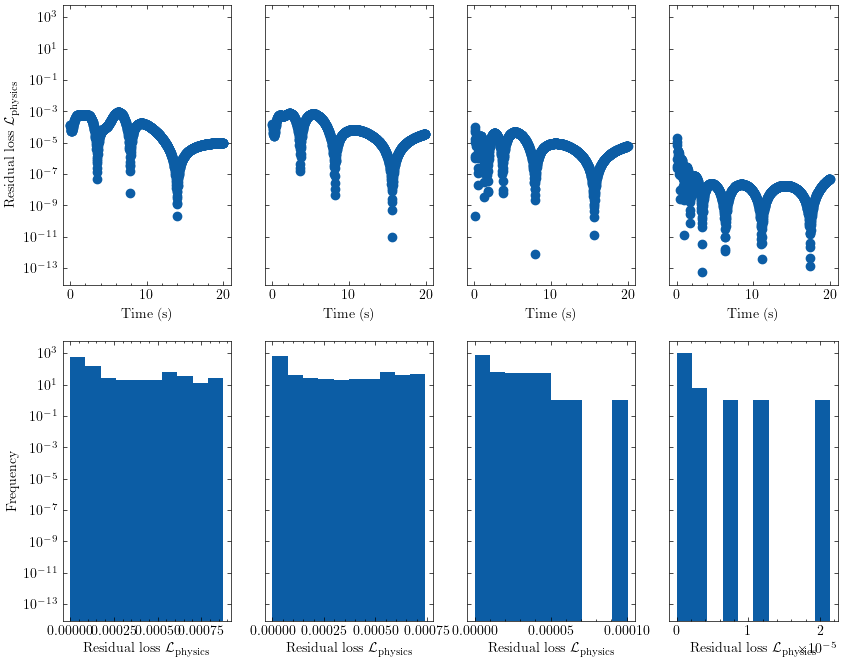

In [36]:
fig, axes = plt.subplots(2, len(PARAM_LIST), figsize=(10, 8), sharey=True)

for idx, param in enumerate(PARAM_LIST):

    residual_losses = []

    for collocation_point in collocation_points:

        pinn = pinn_models[idx]

        phase_angle_pred = pinn.forward(data=collocation_point)

        angular_frequency_pred = torch.autograd.grad(
            outputs=phase_angle_pred,
            inputs=collocation_point,
            grad_outputs=torch.ones_like(phase_angle_pred),
            create_graph=True,
            retain_graph=True,
        )[0]

        angular_acceleration_pred = torch.autograd.grad(
            outputs=angular_frequency_pred,
            inputs=collocation_point,
            grad_outputs=torch.ones_like(angular_frequency_pred),
            create_graph=True,
            retain_graph=True,
        )[0]

        swing_inputs = SwingEquationInputs(
            phase_angle=phase_angle_pred,
            angular_frequency=angular_frequency_pred,
            angular_acceleration=angular_acceleration_pred,
            inertia=INERTIA,
            damping=param,
            mechanical_power=MECHANICAL_POWER,
            voltage_magnitude=VOLTAGE,
            voltages=VOLTAGES,
            phase_angles=PHASE_ANGLES,
            susceptances=SUSCEPTANCES,
            controller_proportional=None,
            controller_integral=None,
        )

        residual = physics_based_loss(swing_inputs=swing_inputs, include_controllers=False)
        residual_losses.append(residual.item())

    skewness_val = skew(a=np.array(residual_losses))
    kurtosis_val = kurtosis(a=np.array(residual_losses), fisher=True)

    print(f"Skewness={skewness_val}\nKurtosis={kurtosis_val}")

    axes[0, idx].semilogy(collocation_points.detach().numpy(), residual_losses, 'o')
    axes[0, idx].set_xlabel('Time (s)')

    if idx == 0:
        axes[0, idx].set_ylabel(r'Residual loss $\mathcal{L}_{\mathrm{physics}}$')
        axes[1, idx].set_ylabel("Frequency")

    axes[1, idx].hist(residual_losses, log=False)
    axes[1, idx].set_xlabel(r'Residual loss $\mathcal{L}_{\mathrm{physics}}$')

plt.show()

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


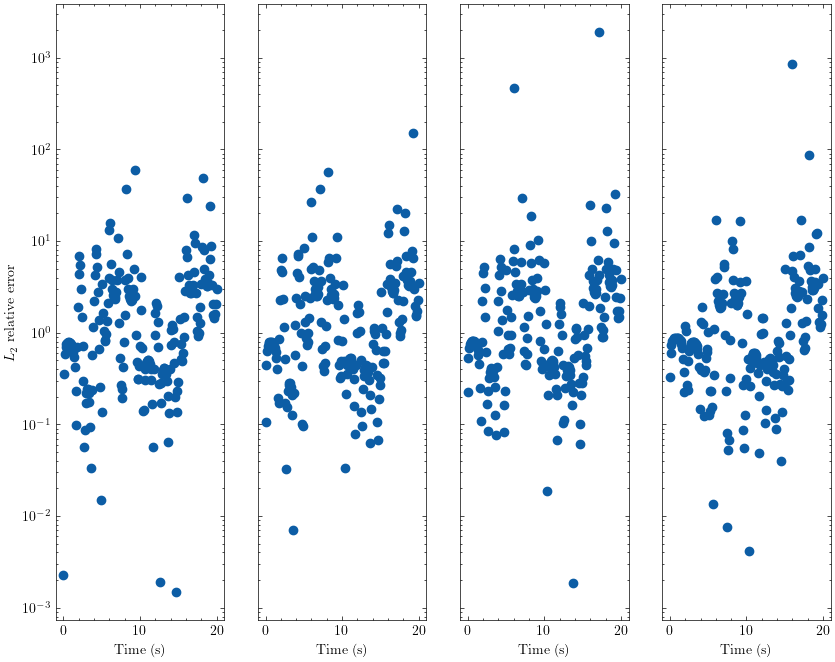

In [37]:
fig, axes = plt.subplots(1, len(PARAM_LIST), figsize=(10, 8), sharey=True)

for idx, param in enumerate(PARAM_LIST):

    test_performance = []

    for time_idx, time in enumerate(times_tensor):
        
        pinn = pinn_models[idx]

        ground_truth_phase_angle = numerical_solutions_exact_tensor[0, time_idx, idx].view(1)

        phase_angle_pred = pinn.forward(data=time)

        angular_frequency_pred = torch.autograd.grad(
            outputs=phase_angle_pred,
            inputs=time,
            grad_outputs=torch.ones_like(phase_angle_pred),
            create_graph=True,
            retain_graph=True,
        )[0]

        _, l2_rel = l2_error(pred=phase_angle_pred, ground_truth=ground_truth_phase_angle, dim=0)
        test_performance.append(l2_rel.item())

    print(type(numerical_domain))
    axes[idx].semilogy(numerical_domain, test_performance, 'o')
    axes[idx].set_xlabel('Time (s)')

    if idx == 0:
        axes[idx].set_ylabel(r"$L_2$ relative error")

plt.show()

## Plot the loss landscapes and contour plots for the PINNs

/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/venv/lib/python3.13/site-packages/mpl_toolkits/mplot3d/proj3d.py:135: RuntimeWarning: divide by zero encountered in dot
  vecw = np.dot(M, vec.data)
/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/venv/lib/python3.13/site-packages/mpl_toolkits/mplot3d/proj3d.py:135: RuntimeWarning: overflow encountered in dot
  vecw = np.dot(M, vec.data)
/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/venv/lib/python3.13/site-packages/mpl_toolkits/mplot3d/proj3d.py:135: RuntimeWarning: invalid value encountered in dot
  vecw = np.dot(M, vec.data)


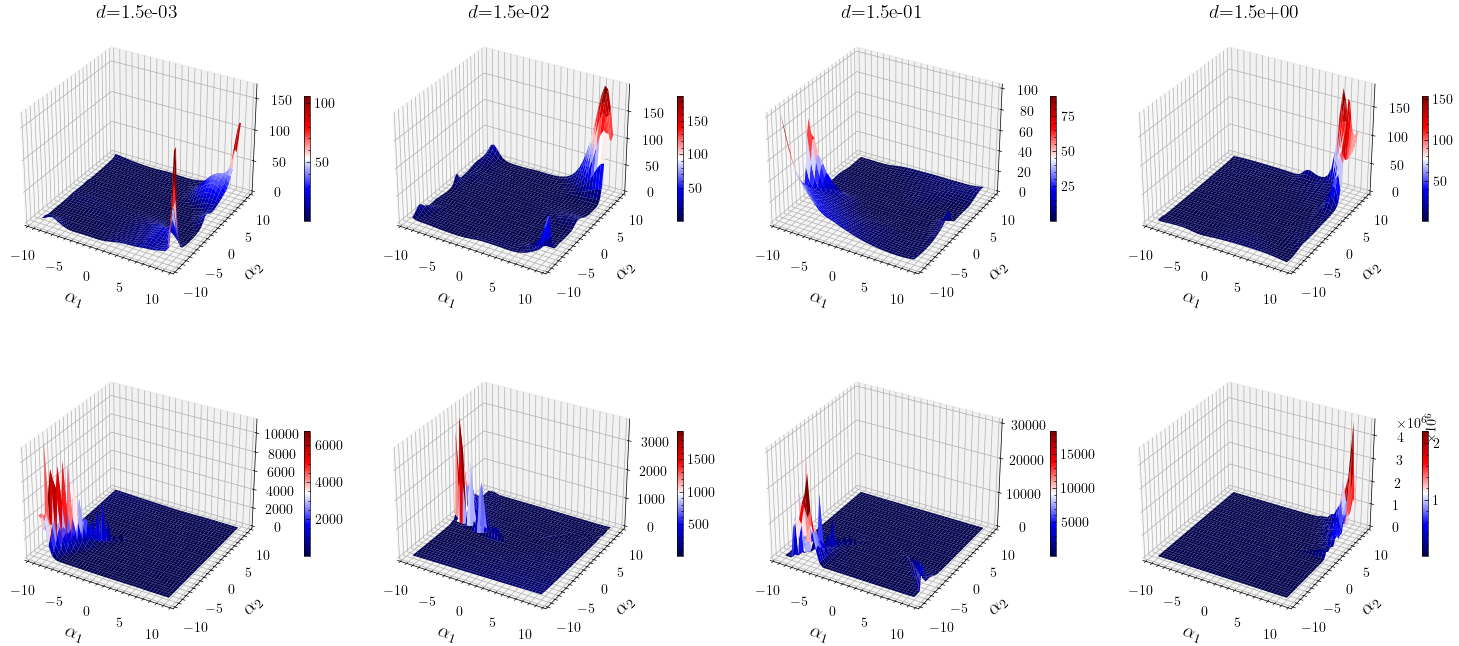

In [38]:
# all_losses = np.array([ls.flatten() for ls in [*loss_landscapes_random, *loss_landscapes_hessian]]).flatten()
# log_losses = [np.log(loss) for loss in all_losses]
# vmin = np.min([np.min(log_loss) for log_loss in log_losses])
# vmax = np.max([np.max(log_loss) for log_loss in log_losses])

fig, ax = plt.subplots(2, len(PARAM_LIST), figsize=(15, 12), subplot_kw={'projection': '3d'})

# Plot the random direction vector subspace projection of the loss landscape
for idx, param in zip(range(4), PARAM_LIST):
    surf_random = ax[0, idx].plot_surface(
        ALPHA_1,
        ALPHA_2,
        (loss_landscapes_random[idx]),
        cmap=CMAP,
        # vmin=vmin,
        # vmax=vmax,
        linewidth=0,
        antialiased=True
    )
    
    fig.colorbar(surf_random, ax=ax[0, idx], shrink=0.15, orientation='vertical', pad=0.1)
    ax[0, idx].set_xlabel(r'$\alpha_1$', fontsize=14)
    ax[0, idx].set_ylabel(r'$\alpha_2$', fontsize=14)
    # ax[0, idx].set_zlim(vmin, vmax)

    if TOP_PLOT:
        ax[0, idx].set_title(f'${VARYING_PARAM_NOTATION}$='+f"{param:.1e}", fontsize=14)

# Plot the Hessian eigenvectors subspace projection of the loss landscape
for idx, param in zip(range(4), PARAM_LIST):
    surf_hessian = ax[1, idx].plot_surface(
        ALPHA_1,
        ALPHA_2,
        (loss_landscapes_hessian[idx]),
        cmap=CMAP,
        # vmin=vmin,
        # vmax=vmax,
        linewidth=0,
        antialiased=True
    )

    fig.colorbar(surf_hessian, ax=ax[1, idx], shrink=0.15, orientation='vertical', pad=0.1)
    ax[1, idx].set_xlabel(r'$\alpha_1$', fontsize=14)
    ax[1, idx].set_ylabel(r'$\alpha_2$', fontsize=14)
    # ax[1, idx].set_zlim(vmin, vmax)

plt.subplots_adjust(left=0.1, right=0.9, hspace=-0.7)
plt.tight_layout()

# Output the plots as PDF to the desired directory
loss_landscape_image_name = f"pinn/{VARYING_PARAM}_loss_landscape_random_seed_{SEED}.pdf"

if SAVE:
    print("Saving...")
    plt.savefig(fname=PATH_TO_IM_DIR+loss_landscape_image_name, format="pdf", bbox_inches="tight")

plt.show()

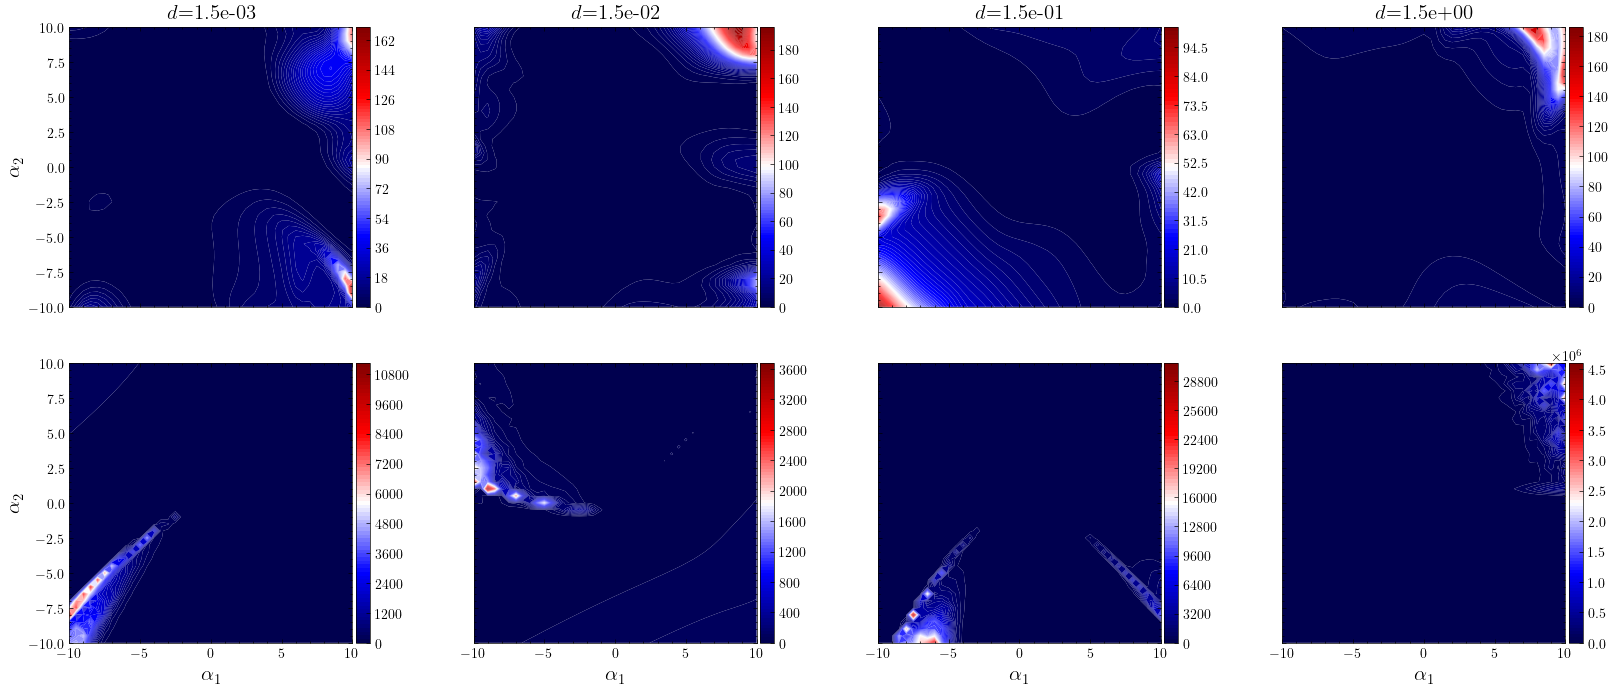

In [39]:
fig, ax = plt.subplots(2, len(PARAM_LIST), figsize=(20, 8), sharex=True, sharey=True)

num_levels = 100
# levels = np.linspace(vmin, vmax, num_levels)

contours_pinn = []

for index, (idx, param) in enumerate(zip(range(4), PARAM_LIST)):
    contour_random = ax[0, idx].contourf(
        ALPHA_1,
        ALPHA_2,
        (loss_landscapes_random[index]),
        cmap=CMAP,
        levels=num_levels,
        antialiased=True
        # vmax=vmax,
        # vmin=vmin
    )
    contours_pinn.append(contour_random)
    fig.colorbar(contour_random, ax=ax[0, idx], shrink=1, orientation='vertical', pad=0.01)

    
    if index == 0:
        ax[0, idx].set_ylabel(r'$\alpha_2$', fontsize=15)

    if TOP_PLOT:
        ax[0, idx].set_title(f'${VARYING_PARAM_NOTATION}$='+f"{param:.1e}", fontsize=15)


for index, (idx, param) in enumerate(zip(range(4), PARAM_LIST)):
    contour_hessian = ax[1, idx].contourf(
        ALPHA_1,
        ALPHA_2,
        (loss_landscapes_hessian[index]),
        cmap=CMAP,
        levels=num_levels,
        antialiased=True
        # vmax=vmax,
        # vmin=vmin
    )
    contours_pinn.append(contour_hessian)
    fig.colorbar(contour_hessian, ax=ax[1, idx], shrink=1, orientation='vertical', pad=0.01)
    
    ax[1, idx].set_xlabel(r'$\alpha_1$', fontsize=15)

    if index == 0:
        ax[1, idx].set_ylabel(r'$\alpha_2$', fontsize=15)

# Shared colorbar
# cbar = fig.colorbar(contours_pinn[0], ax=ax.ravel().tolist(), shrink=1, orientation='vertical', pad=0.01)

contour_image_name = f"pinn/{VARYING_PARAM}_contour_random_seed_{SEED}.pdf"

if SAVE:
    print("Saving...")
    plt.savefig(fname=PATH_TO_IM_DIR+contour_image_name, format="pdf", bbox_inches="tight")

plt.show()

## Plot the PINN vs RK45 solution
## The cell below requires editing the parameter being varied

<>:73: SyntaxWarning: invalid escape sequence '\d'
<>:74: SyntaxWarning: invalid escape sequence '\d'
<>:73: SyntaxWarning: invalid escape sequence '\d'
<>:74: SyntaxWarning: invalid escape sequence '\d'
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_3941/2107128721.py:73: SyntaxWarning: invalid escape sequence '\d'
  ax[0, index].set_ylabel("Phase Angle $\delta$ (rad)", fontsize=14)
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_3941/2107128721.py:74: SyntaxWarning: invalid escape sequence '\d'
  ax[1, index].set_ylabel("Angular Frequency $\dot{\delta}$ (rad/s)", fontsize=14)


L2 absolute error: 4.76e+00
L2 relative error: 6.16e-01
L2 absolute error: 3.59e+00
L2 relative error: 5.60e-01
L2 absolute error: 2.54e-01
L2 relative error: 8.37e-02
L2 absolute error: 1.62e-03
L2 relative error: 1.89e-03


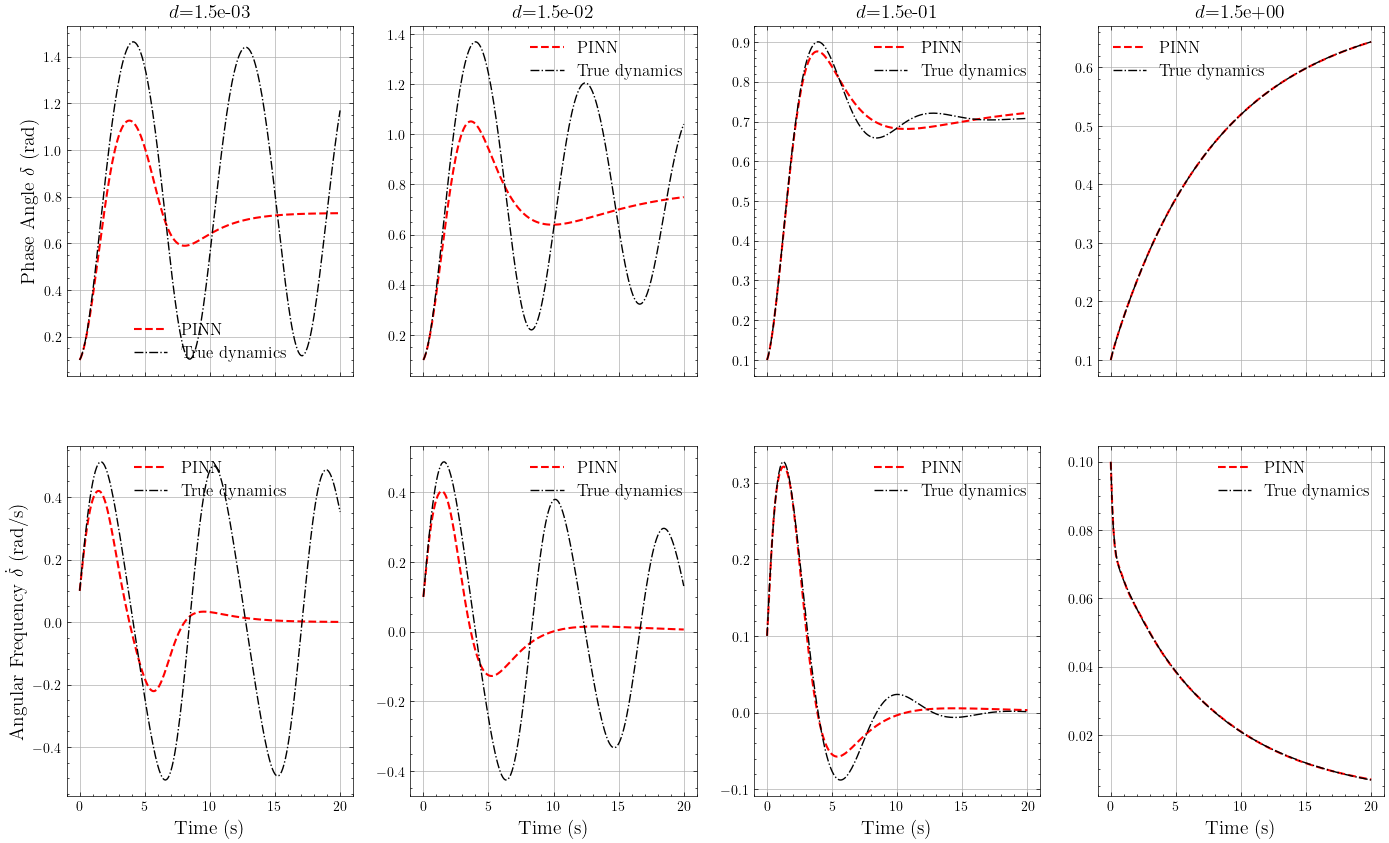

In [40]:
abs_errors_pinns = []
rel_errors_pinns = []

fig, ax = plt.subplots(2, len(PARAM_LIST), figsize=(17, 10), sharex=True)

for index, param in enumerate(PARAM_LIST):

    solution, _, times = swing_ODEs_solver(
        initial_time=0,
        initial_state=INITIAL_STATE.detach().numpy(),
        final_time=20.0,
        timestep=0.1,
        inertia=0.25,
        damping=param,
        mechanical_power=0.13,
        voltage_magnitude=1.0,
        include_controllers=False,
        voltages=np.array([1.0]),
        phase_angles=np.array([0.0]),
        susceptances=np.array([0.2]),
        file_name="test_run",
        save_output_to_file=False,
        controller_proportional=0.05,
        controller_integral=0.1,
    )

    times = torch.tensor(
        data=times.astype(np.float32)[:,None], requires_grad=True
    ).to(device=DEVICE)

    phase_angle_labels = torch.tensor(
        data=solution[0,:].astype(np.float32)[:, None]
    ).to(device=DEVICE)

    angular_frequency_labels = torch.tensor(
        data=solution[1,:].astype(np.float32)[:, None]
    ).to(device=DEVICE)

    phase_angle_pred = pinn_models[index].forward(data=times, initial_state=INITIAL_STATE)

    angular_frequency_pred = torch.autograd.grad(
        outputs=phase_angle_pred,
        inputs=times,
        grad_outputs=torch.ones_like(phase_angle_pred),
        create_graph=True,
        retain_graph=True,
    )[0]

    pred_vector = torch.stack(tensors=(phase_angle_pred, angular_frequency_pred), dim=0)
    label_vector = torch.stack(tensors=(phase_angle_labels, angular_frequency_labels), dim=0)

    l2_abs, l2_rel = l2_error(pred=pred_vector, ground_truth=label_vector)

    print(f"L2 absolute error: {l2_abs:.2e}")
    print(f"L2 relative error: {l2_rel:.2e}")

    abs_errors_pinns.append(l2_abs)
    rel_errors_pinns.append(l2_rel)

    ax[0, index].plot(times.detach().numpy(), phase_angle_pred.detach().numpy(), color='red', linestyle='--', label='PINN', linewidth=1.5)
    ax[0, index].plot(times.detach().numpy(), solution[0, :], color="black", linestyle="-.", label="True dynamics")
    ax[0, index].grid()
    ax[0, index].legend(fontsize=12, loc="best")
    ax[0, index].set_title(f'${VARYING_PARAM_NOTATION}$='+f"{param:.1e}", fontsize=14)

    ax[1, index].plot(times.detach().numpy(), angular_frequency_pred.detach().numpy(), color='red', linestyle='--', label='PINN', linewidth=1.5)
    ax[1, index].plot(times.detach().numpy(), solution[1, :], color="black", linestyle="-.", label="True dynamics")
    ax[1, index].grid()
    ax[1, index].legend(fontsize=12, loc="best")
    ax[1, index].set_xlabel("Time (s)", fontsize=14)

    if index == 0:
        ax[0, index].set_ylabel("Phase Angle $\delta$ (rad)", fontsize=14)
        ax[1, index].set_ylabel("Angular Frequency $\dot{\delta}$ (rad/s)", fontsize=14)

exact_vs_pred_image: str = f"pinn/{VARYING_PARAM}_pinn_vs_ground_truth_seed_{SEED}.pdf"

# plt.subplots_adjust(left=0.1, right=0.9)
# plt.tight_layout()

if SAVE:
    print("Saving...")
    plt.savefig(fname=PATH_TO_IM_DIR+exact_vs_pred_image, format="pdf", bbox_inches="tight")

plt.show()

# Train the vanilla NN

In [41]:
vanilla_nn_hessian_loss_landscapes = []
vanilla_nn_loss_landscapes = []
vanilla_nns = []
vanilla_training_losses = []

for index, param in enumerate(PARAM_LIST):

    print(f"Param value {index+1}")
    print("----------------------\n")

    solution, _, times = swing_ODEs_solver(
        initial_time=0,
        initial_state=INITIAL_STATE.detach().numpy(),
        final_time=20.0,
        timestep=0.1,
        inertia=0.25,
        damping=param,
        mechanical_power=0.13,
        voltage_magnitude=1.0,
        include_controllers=False,
        voltages=np.array([1.0]),
        phase_angles=np.array([0.0]),
        susceptances=np.array([0.2]),
        file_name="test_run",
        save_output_to_file=False,
        controller_proportional=0.05,
        controller_integral=0.1,
    )

    times = np.array([times[id] for id in rand_index]).flatten()
    times = torch.tensor(
        data=times.astype(np.float32)[:, None], requires_grad=True
    ).to(device=DEVICE)

    training_data = np.array([solution[0,:][id] for id in rand_index]).flatten()
    training_data = torch.tensor(
        data=training_data.astype(np.float32)[:, None]
    ).to(device=DEVICE)

    # Define PINN, optimiser and learning rate scheduler
    nn = PINN(activation=ACTIVATION).to(device=DEVICE)

    optimiser = torch.optim.Adam(params=nn.parameters(), lr=LEARNING_RATE)

    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer=optimiser, patience=PATIENCE, factor=SCHEDULER_FACTOR
    )

    MSE_loss = torch.nn.MSELoss()

    # Define array to collect training loss every epoch
    training_loss = []

    for epoch in tqdm(range(EPOCHS)):
        # Obtain PINN predictions and it's time derivatives
        phase_angle_pred = nn.forward(
            data=times, initial_state=INITIAL_STATE
        )

        loss = MSE_loss(phase_angle_pred, training_data)
        training_loss.append(loss.item())
        
        # Backpropogate using reverse/backward-mode AD
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        # lr_scheduler.step(metrics=loss)

        if epoch % PRINT_TRAINING_LOSS_EVERY_EPOCH == 0:
            print(f"Training loss: {loss}")

    vanilla_nns.append(nn)
    vanilla_training_losses.append(training_loss)

    hessian_comp = hessian(nn, MSE_loss, data=(times, training_data), cuda=False)
    top_eigenvalues, top_eigenvectors = hessian_comp.eigenvalues(top_n=2)
    
    first_eigenvector = [t.squeeze().flatten() for t in top_eigenvectors[0]]
    first_eigenvector = torch.cat(first_eigenvector, dim=0)

    second_eigenvector = [t.squeeze().flatten() for t in top_eigenvectors[1]]
    second_eigenvector = torch.cat(second_eigenvector, dim=0)

    MINIMISER = parameters_to_vector(nn.parameters())

    loss_landscape = []
    loss_landscape_hessian = []

    nn.eval()

    for i in alpha_1:
        for j in alpha_2:
            perturbation = MINIMISER + i * direction_vec_1 + j * direction_vec_2
            perturbation_hessian = MINIMISER + i * first_eigenvector + j * second_eigenvector

            vector_to_parameters(vec=perturbation, parameters=nn.parameters())

            phase_angle_pred = nn.forward(
                data=times, initial_state=INITIAL_STATE
            )

            loss_perturb = MSE_loss(phase_angle_pred, training_data)

            loss_landscape.append(loss_perturb.detach().numpy())

            # Reset PINN learnt parameters back to the minimiser
            vector_to_parameters(vec=MINIMISER, parameters=nn.parameters())

            # Repeat for Hessian eigenvectors
            vector_to_parameters(vec=perturbation_hessian, parameters=nn.parameters())

            phase_angle_pred = nn.forward(
                data=times, initial_state=INITIAL_STATE
            )

            loss_perturb_hessian = MSE_loss(phase_angle_pred, training_data)

            loss_landscape_hessian.append(loss_perturb_hessian.detach().numpy())

            # Reset PINN learnt parameters back to the minimiser
            vector_to_parameters(vec=MINIMISER, parameters=nn.parameters())

    loss_landscape = np.array(loss_landscape).reshape(alpha_1.shape[0], alpha_2.shape[0])
    loss_landscape_hessian = np.array(loss_landscape_hessian).reshape(alpha_1.shape[0], alpha_2.shape[0])

    vanilla_nn_loss_landscapes.append(loss_landscape)
    vanilla_nn_hessian_loss_landscapes.append(loss_landscape_hessian)

Param value 1
----------------------



  6%|▌         | 283/5000 [00:00<00:01, 2822.83it/s]

Training loss: 1.061057686805725
Training loss: 0.10180452466011047
Training loss: 0.01892145909368992
Training loss: 0.005576087161898613
Training loss: 0.001431486802175641
Training loss: 0.001545651350170374


 23%|██▎       | 1161/5000 [00:00<00:01, 2908.65it/s]

Training loss: 0.0011733127757906914
Training loss: 0.0007079332717694342
Training loss: 0.0011777584441006184
Training loss: 0.0005664282944053411
Training loss: 0.0008269775426015258
Training loss: 0.013210487551987171


 35%|███▍      | 1745/5000 [00:00<00:01, 2905.08it/s]

Training loss: 0.0006852797814644873
Training loss: 0.002543792361393571
Training loss: 0.0004893001751042902
Training loss: 0.0004620458639692515
Training loss: 0.0028547144029289484
Training loss: 0.0001611747866263613


 47%|████▋     | 2329/5000 [00:00<00:00, 2906.37it/s]

Training loss: 0.001705757575109601
Training loss: 0.0025479330215603113
Training loss: 0.0003236987395212054
Training loss: 0.0004497519403230399
Training loss: 0.0023288880474865437
Training loss: 0.0001237789256265387


 58%|█████▊    | 2918/5000 [00:01<00:00, 2887.10it/s]

Training loss: 0.00028011956601403654
Training loss: 0.00033244528458453715
Training loss: 0.0001257221301784739
Training loss: 0.00019360649457667023
Training loss: 0.0005965280579403043
Training loss: 0.0002248156233690679


 70%|███████   | 3510/5000 [00:01<00:00, 2924.31it/s]

Training loss: 0.00012627133401110768
Training loss: 0.000734075962100178
Training loss: 0.0003055268316529691
Training loss: 0.0005569722270593047
Training loss: 0.00022578089556191117
Training loss: 6.252070306800306e-05


 82%|████████▏ | 4096/5000 [00:01<00:00, 2900.98it/s]

Training loss: 4.029523188364692e-05
Training loss: 0.00030404282733798027
Training loss: 0.00014575156092178077
Training loss: 7.071974687278271e-05
Training loss: 0.0009508591610938311
Training loss: 8.574919047532603e-05


 94%|█████████▍| 4690/5000 [00:01<00:00, 2933.86it/s]

Training loss: 0.0005286102532409132
Training loss: 0.0004678225377574563
Training loss: 0.0008635178674012423
Training loss: 0.00018377238302491605
Training loss: 0.0003330846084281802
Training loss: 0.0006711767637170851


100%|██████████| 5000/5000 [00:01<00:00, 2908.41it/s]


Training loss: 5.3614530770573765e-05
Training loss: 0.000981375458650291
Param value 2
----------------------



  6%|▌         | 293/5000 [00:00<00:01, 2928.86it/s]

Training loss: 0.988281786441803
Training loss: 0.0875764787197113
Training loss: 0.008257733657956123
Training loss: 0.003889931133016944
Training loss: 0.002438845345750451
Training loss: 0.008550815284252167


 23%|██▎       | 1171/5000 [00:00<00:01, 2864.68it/s]

Training loss: 0.0004934011958539486
Training loss: 0.000408537860494107
Training loss: 0.0009155852603726089
Training loss: 0.0007377013098448515
Training loss: 5.632060128846206e-05
Training loss: 0.0005779576022177935


 35%|███▍      | 1743/5000 [00:00<00:01, 2834.78it/s]

Training loss: 0.0002591061347629875
Training loss: 0.0005626104539260268
Training loss: 0.0001307752390857786
Training loss: 0.0003972228732891381
Training loss: 0.0004938120255246758
Training loss: 9.68788008322008e-05


 46%|████▌     | 2312/5000 [00:00<00:00, 2834.78it/s]

Training loss: 0.0008716704905964434
Training loss: 0.0005574887618422508
Training loss: 0.00010742760059656575
Training loss: 0.0009295003837905824
Training loss: 0.0001628964237170294
Training loss: 2.4608381863799877e-05


 58%|█████▊    | 2878/5000 [00:01<00:00, 2810.59it/s]

Training loss: 0.00019029858231078833
Training loss: 0.00016880359908100218
Training loss: 0.00036182490293867886
Training loss: 0.00018949633522424847
Training loss: 0.0003280206583440304
Training loss: 0.00016758886340539902


 69%|██████▉   | 3440/5000 [00:01<00:00, 2790.07it/s]

Training loss: 0.0001741366577334702
Training loss: 0.00033524225000292063
Training loss: 0.00021387259766925126
Training loss: 0.0005631558015011251
Training loss: 0.0006808643811382353
Training loss: 8.959597471402958e-05


 80%|███████▉  | 3999/5000 [00:01<00:00, 2759.38it/s]

Training loss: 0.00019422764307819307
Training loss: 0.0011856629280373454
Training loss: 3.0215100196073763e-05
Training loss: 7.802719483152032e-05
Training loss: 0.0009484136826358736
Training loss: 0.0002877268707379699


 91%|█████████▏| 4570/5000 [00:01<00:00, 2807.69it/s]

Training loss: 3.095898136962205e-05
Training loss: 7.483315857825801e-05
Training loss: 0.00043153605656698346
Training loss: 7.958335481816903e-05
Training loss: 0.00020397937623783946
Training loss: 0.00012562349729705602


100%|██████████| 5000/5000 [00:01<00:00, 2826.27it/s]


Training loss: 7.915115565992892e-05
Training loss: 3.136944360448979e-05
Param value 3
----------------------



  6%|▌         | 288/5000 [00:00<00:01, 2875.23it/s]

Training loss: 0.7023823857307434
Training loss: 0.0029733756091445684
Training loss: 0.00037722132401540875
Training loss: 0.00019881190382875502
Training loss: 0.0008736537420190871
Training loss: 0.00012173308641649783


 23%|██▎       | 1157/5000 [00:00<00:01, 2868.23it/s]

Training loss: 8.001470996532589e-05
Training loss: 0.00018255376198794693
Training loss: 9.638914343668148e-05
Training loss: 8.929581963457167e-05
Training loss: 8.434203482465819e-05
Training loss: 7.716265827184543e-05


 35%|███▍      | 1739/5000 [00:00<00:01, 2887.70it/s]

Training loss: 7.06116043147631e-05
Training loss: 5.8267545682610944e-05
Training loss: 1.8615159206092358e-05
Training loss: 1.0333567843190394e-05
Training loss: 7.929858838906512e-06
Training loss: 1.7506001313449815e-05


 47%|████▋     | 2327/5000 [00:00<00:00, 2913.88it/s]

Training loss: 7.164485396060627e-06
Training loss: 5.377371508075157e-06
Training loss: 4.477274615055649e-06
Training loss: 3.937385827157414e-06
Training loss: 3.561172889021691e-06
Training loss: 8.736341987969354e-05


 58%|█████▊    | 2909/5000 [00:01<00:00, 2877.57it/s]

Training loss: 3.975676008849405e-06
Training loss: 2.9707953217439353e-06
Training loss: 2.56583825830603e-06
Training loss: 2.3093632535164943e-06
Training loss: 2.1175953861529706e-06
Training loss: 1.9668887034640647e-06


 70%|██████▉   | 3481/5000 [00:01<00:00, 2810.96it/s]

Training loss: 1.8465951825419324e-06
Training loss: 1.7501970432931557e-06
Training loss: 1.9997080471512163e-06
Training loss: 1.6544928485018318e-06
Training loss: 1.572191195009509e-06
Training loss: 1.5224281924020033e-06


 81%|████████  | 4052/5000 [00:01<00:00, 2824.66it/s]

Training loss: 1.4826223377895076e-06
Training loss: 0.00027432243223302066
Training loss: 1.5370781056844862e-06
Training loss: 1.4628531062044203e-06
Training loss: 1.4343983139042393e-06
Training loss: 1.4089423530094791e-06


 93%|█████████▎| 4631/5000 [00:01<00:00, 2857.85it/s]

Training loss: 2.2716847070114454e-06
Training loss: 1.8013993212662172e-06
Training loss: 1.4116477586867404e-06
Training loss: 1.908306330733467e-06
Training loss: 1.4281271205618395e-06
Training loss: 1.4046039495951845e-06


100%|██████████| 5000/5000 [00:01<00:00, 2858.81it/s]


Training loss: 7.562778591818642e-06
Training loss: 1.4739817970621516e-06
Param value 4
----------------------



  6%|▌         | 281/5000 [00:00<00:01, 2802.52it/s]

Training loss: 0.3372315764427185
Training loss: 3.661360824480653e-05
Training loss: 1.6961615983746015e-05
Training loss: 6.058884537196718e-06
Training loss: 2.699773176573217e-06
Training loss: 1.966379841178423e-06


 23%|██▎       | 1131/5000 [00:00<00:01, 2828.38it/s]

Training loss: 1.6816203469716129e-06
Training loss: 1.4484387520496966e-06
Training loss: 1.2305604286666494e-06
Training loss: 1.0281274853696232e-06
Training loss: 8.429966555922874e-07
Training loss: 1.4147097999739344e-06


 34%|███▍      | 1707/5000 [00:00<00:01, 2845.09it/s]

Training loss: 1.3671334500031662e-06
Training loss: 9.20445529573044e-07
Training loss: 6.994914087954385e-07
Training loss: 2.4497754566255026e-05
Training loss: 8.198755949706538e-07
Training loss: 5.632126089949452e-07


 46%|████▌     | 2278/5000 [00:00<00:00, 2843.94it/s]

Training loss: 3.8759696963097667e-07
Training loss: 8.538279985259578e-07
Training loss: 3.9380384464493545e-07
Training loss: 2.4359965777875914e-07
Training loss: 6.826185767749848e-07
Training loss: 2.820462441377458e-07


 57%|█████▋    | 2860/5000 [00:01<00:00, 2879.42it/s]

Training loss: 9.396541827300098e-06
Training loss: 3.6483388043961895e-07
Training loss: 1.9610010326687188e-07
Training loss: 5.95691835769685e-06
Training loss: 2.8199309554111096e-07
Training loss: 3.9139831642387435e-05


 69%|██████▊   | 3437/5000 [00:01<00:00, 2877.46it/s]

Training loss: 4.66232933149513e-07
Training loss: 2.2077979622281418e-07
Training loss: 6.420492809411371e-06
Training loss: 3.3230838880626834e-07
Training loss: 5.7696146541275084e-05
Training loss: 5.169657129044936e-07


 80%|████████  | 4011/5000 [00:01<00:00, 2857.46it/s]

Training loss: 1.9954815400069492e-07
Training loss: 8.948853178480931e-07
Training loss: 2.452915168760228e-07
Training loss: 1.086893280444201e-05
Training loss: 2.440856405883096e-07
Training loss: 6.194296020112233e-06


 92%|█████████▏| 4589/5000 [00:01<00:00, 2870.84it/s]

Training loss: 1.8947189062146208e-07
Training loss: 1.2767825410264777e-06
Training loss: 2.605005420264206e-06
Training loss: 3.0608543966081925e-07
Training loss: 1.0370971722295508e-05
Training loss: 1.1076853070335346e-06


100%|██████████| 5000/5000 [00:01<00:00, 2858.26it/s]


Training loss: 2.1256545323922182e-07
Training loss: 1.1522438398969825e-06


In [42]:
# First check if the values of the loss in both loss landscapes at alpha_1 = alpha_2 = 0 are equal
for loss, random, hessian_ in zip(vanilla_training_losses, vanilla_nn_loss_landscapes, vanilla_nn_hessian_loss_landscapes):
    print(loss[-1])
    print(random[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX])
    print(hessian_[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX])
    print("--------------------")
    assert np.isclose(random[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX], hessian_[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX], atol=1e-8, rtol=1e-8)
    assert np.isclose(random[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX], loss[-1], atol=1e-6, rtol=1e-6)
    assert np.isclose(hessian_[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX], loss[-1], atol=1e-6, rtol=1e-6)

0.001377454143948853
0.0026295364
0.0026295364
--------------------


AssertionError: 

## Plot the training loss against epochs for the PINNs and vanilla NNs

<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_3941/1709823135.py:11: SyntaxWarning: invalid escape sequence '\m'
  ax[0].set_ylabel("Training loss $\mathcal{L}_{\mathrm{NN}}$ (log scale)", fontsize=12)
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_3941/1709823135.py:24: SyntaxWarning: invalid escape sequence '\m'
  ax[1].set_ylabel("Training loss $\mathcal{L}_{\mathrm{PINN}}$ (log scale)", fontsize=12)


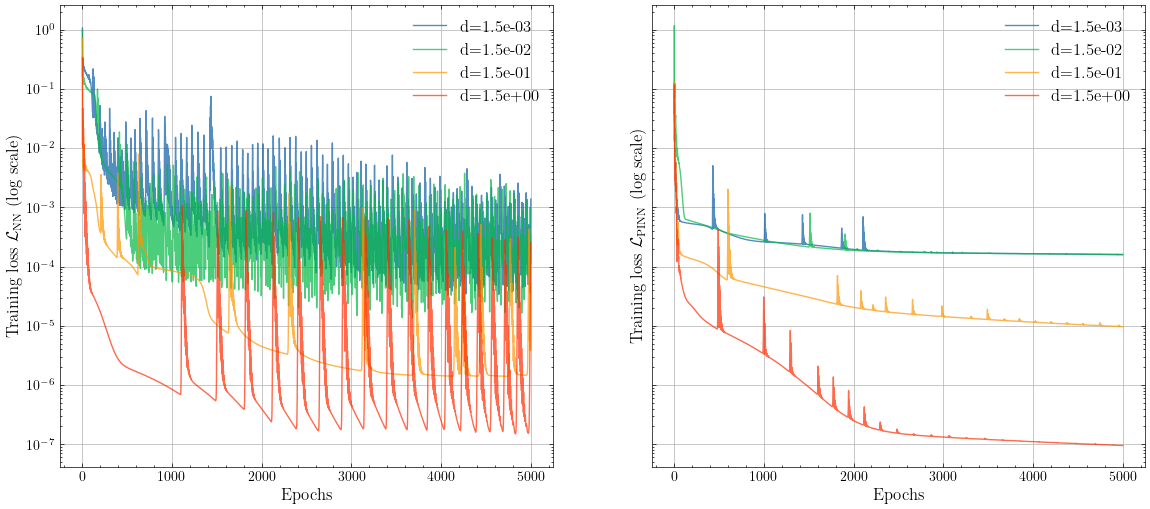

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for (param, training_loss) in zip(PARAM_LIST, vanilla_training_losses):
    ax[0].semilogy(
        range(1, EPOCHS+1),
        training_loss,
        alpha=0.7,
        label=f"{VARYING_PARAM_NOTATION}={param:.1e}"
    )

ax[0].set_ylabel("Training loss $\mathcal{L}_{\mathrm{NN}}$ (log scale)", fontsize=12)
ax[0].set_xlabel("Epochs", fontsize=12)
ax[0].grid()
ax[0].legend(loc="best", fontsize=12)

for (param, training_loss) in zip(PARAM_LIST, training_losses):
    ax[1].semilogy(
        range(1, EPOCHS+1),
        training_loss,
        alpha=0.7,
        label=f"{VARYING_PARAM_NOTATION}={param:.1e}"
    )

ax[1].set_ylabel("Training loss $\mathcal{L}_{\mathrm{PINN}}$ (log scale)", fontsize=12)
ax[1].set_xlabel("Epochs", fontsize=12)
ax[1].grid()
ax[1].legend(loc="best", fontsize=12)

training_losses_plot = f"{VARYING_PARAM}_training_losses_seed_{SEED}.pdf"

# plt.savefig(fname=PATH_TO_IM_DIR+training_losses_plot, format="pdf", bbox_inches="tight")

plt.show()

## Plot the loss landscapes and contour plots for the vanilla NNs

/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/venv/lib/python3.13/site-packages/mpl_toolkits/mplot3d/proj3d.py:135: RuntimeWarning: divide by zero encountered in dot
  vecw = np.dot(M, vec.data)
/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/venv/lib/python3.13/site-packages/mpl_toolkits/mplot3d/proj3d.py:135: RuntimeWarning: overflow encountered in dot
  vecw = np.dot(M, vec.data)
/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/venv/lib/python3.13/site-packages/mpl_toolkits/mplot3d/proj3d.py:135: RuntimeWarning: invalid value encountered in dot
  vecw = np.dot(M, vec.data)


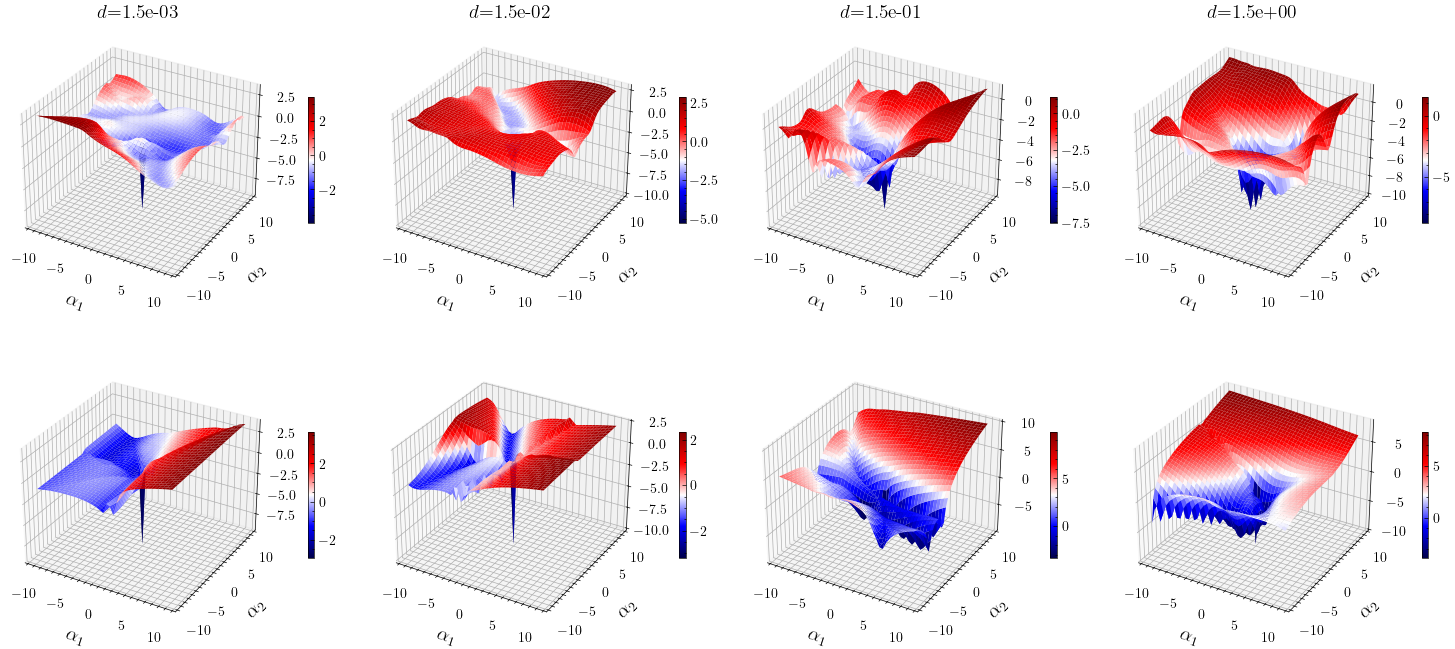

In [ ]:
all_losses = np.array([ls.flatten() for ls in [*vanilla_nn_loss_landscapes, *vanilla_nn_hessian_loss_landscapes, *loss_landscapes_random, *loss_landscapes_hessian]]).flatten()
log_losses = [np.log(loss) for loss in all_losses]
vmin = np.min([np.min(log_loss) for log_loss in log_losses])
vmax = np.max([np.max(log_loss) for log_loss in log_losses])

fig, ax = plt.subplots(2, len(PARAM_LIST), figsize=(15, 12), subplot_kw={'projection': '3d'})

for index, (idx, param) in enumerate(zip(range(4), PARAM_LIST)):
    surf_random = ax[0, idx].plot_surface(
        ALPHA_1,
        ALPHA_2,
        np.log(vanilla_nn_loss_landscapes[index]),
        cmap=CMAP,
        # vmin=vmin,
        # vmax=vmax,
        linewidth=0,
        antialiased=True
    )
    fig.colorbar(surf_random, ax=ax[0, idx], shrink=0.15, orientation='vertical', pad=0.1)
    ax[0, idx].set_xlabel(r'$\alpha_1$', fontsize=14)
    ax[0, idx].set_ylabel(r'$\alpha_2$', fontsize=14)

    if TOP_PLOT:
        ax[0, idx].set_title(f'${VARYING_PARAM_NOTATION}$='+f"{param:.1e}", fontsize=14)

for index, (idx, param) in enumerate(zip(range(4), PARAM_LIST)):
    surf_hessian = ax[1, idx].plot_surface(
        ALPHA_1,
        ALPHA_2,
        np.log(vanilla_nn_hessian_loss_landscapes[index]),
        cmap=CMAP,
        # vmin=vmin,
        # vmax=vmax,
        linewidth=0,
        antialiased=True
    )
    fig.colorbar(surf_hessian, ax=ax[1, idx], shrink=0.15, orientation='vertical', pad=0.1)
    ax[1, idx].set_xlabel(r'$\alpha_1$', fontsize=14)
    ax[1, idx].set_ylabel(r'$\alpha_2$', fontsize=14)

plt.subplots_adjust(left=0.1, right=0.9, hspace=-0.7)
plt.tight_layout()

contour_image_name = f"vanilla_nn/{VARYING_PARAM}_loss_landscape_random_seed_{SEED}.pdf"

if SAVE:
    print("Saving...")
    plt.savefig(fname=PATH_TO_IM_DIR+contour_image_name, format="pdf", bbox_inches="tight")

plt.show()

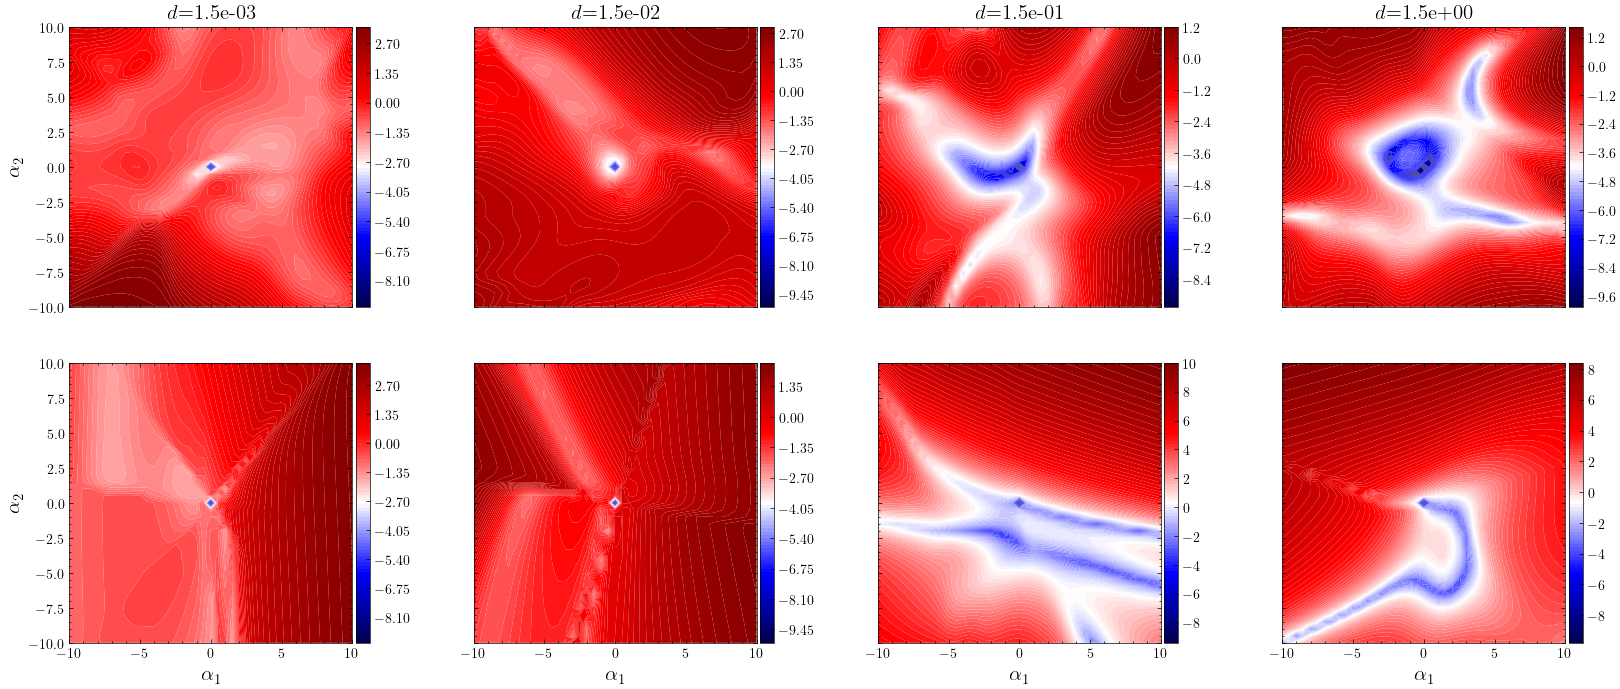

In [ ]:
fig, ax = plt.subplots(2, len(PARAM_LIST), figsize=(20, 8), sharex=True, sharey=True)

contours_vanilla = []

for index, (idx, param) in enumerate(zip(range(4), PARAM_LIST)):
    contour_random = ax[0, idx].contourf(
        ALPHA_1,
        ALPHA_2,
        np.log(vanilla_nn_loss_landscapes[index]),
        cmap=CMAP,
        levels=num_levels,
        antialiased=True
        # vmax=vmax,
        # vmin=vmin
    )
    contours_vanilla.append(contour_random)
    fig.colorbar(contour_random, ax=ax[0, idx], shrink=1, orientation='vertical', pad=0.01)

    if index == 0:
        ax[0, idx].set_ylabel(r'$\alpha_2$', fontsize=15)

    if TOP_PLOT:
        ax[0, idx].set_title(f'${VARYING_PARAM_NOTATION}$='+f"{param:.1e}", fontsize=15)


for index, (idx, param) in enumerate(zip(range(4), PARAM_LIST)):
    contour_hessian = ax[1, idx].contourf(
        ALPHA_1,
        ALPHA_2,
        np.log(vanilla_nn_hessian_loss_landscapes[index]),
        cmap=CMAP,
        levels=num_levels,
        antialiased=True
        # vmax=vmax,
        # vmin=vmin
    )
    contours_vanilla.append(contour_hessian)
    fig.colorbar(contour_hessian, ax=ax[1, idx], shrink=1, orientation='vertical', pad=0.01)
    ax[1, idx].set_xlabel(r'$\alpha_1$', fontsize=15)

    if index == 0:
        ax[1, idx].set_ylabel(r'$\alpha_2$', fontsize=15)

# Shared colorbar
# cbar = fig.colorbar(contours_vanilla[0], ax=ax.ravel().tolist(), shrink=1, orientation='vertical', pad=0.01)
contour_image_name = f"vanilla_nn/{VARYING_PARAM}_contour_random_seed_{SEED}.pdf"

if SAVE:
    print("Saving...")
    plt.savefig(fname=PATH_TO_IM_DIR+contour_image_name, format="pdf", bbox_inches="tight")

plt.show()

<>:74: SyntaxWarning: invalid escape sequence '\d'
<>:75: SyntaxWarning: invalid escape sequence '\d'
<>:74: SyntaxWarning: invalid escape sequence '\d'
<>:75: SyntaxWarning: invalid escape sequence '\d'
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_1098/3871533940.py:74: SyntaxWarning: invalid escape sequence '\d'
  ax[0, index].set_ylabel("Phase Angle $\delta$ (rad)", fontsize=14)
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_1098/3871533940.py:75: SyntaxWarning: invalid escape sequence '\d'
  ax[1, index].set_ylabel("Angular Frequency $\dot{\delta}$ (rad/s)", fontsize=14)


L2 absolute error: 2.09e-01
L2 relative error: 3.25e-02
L2 absolute error: 1.42e-01
L2 relative error: 2.67e-02
L2 absolute error: 1.15e-01
L2 relative error: 3.67e-02
L2 absolute error: 7.49e-02
L2 relative error: 5.24e-02


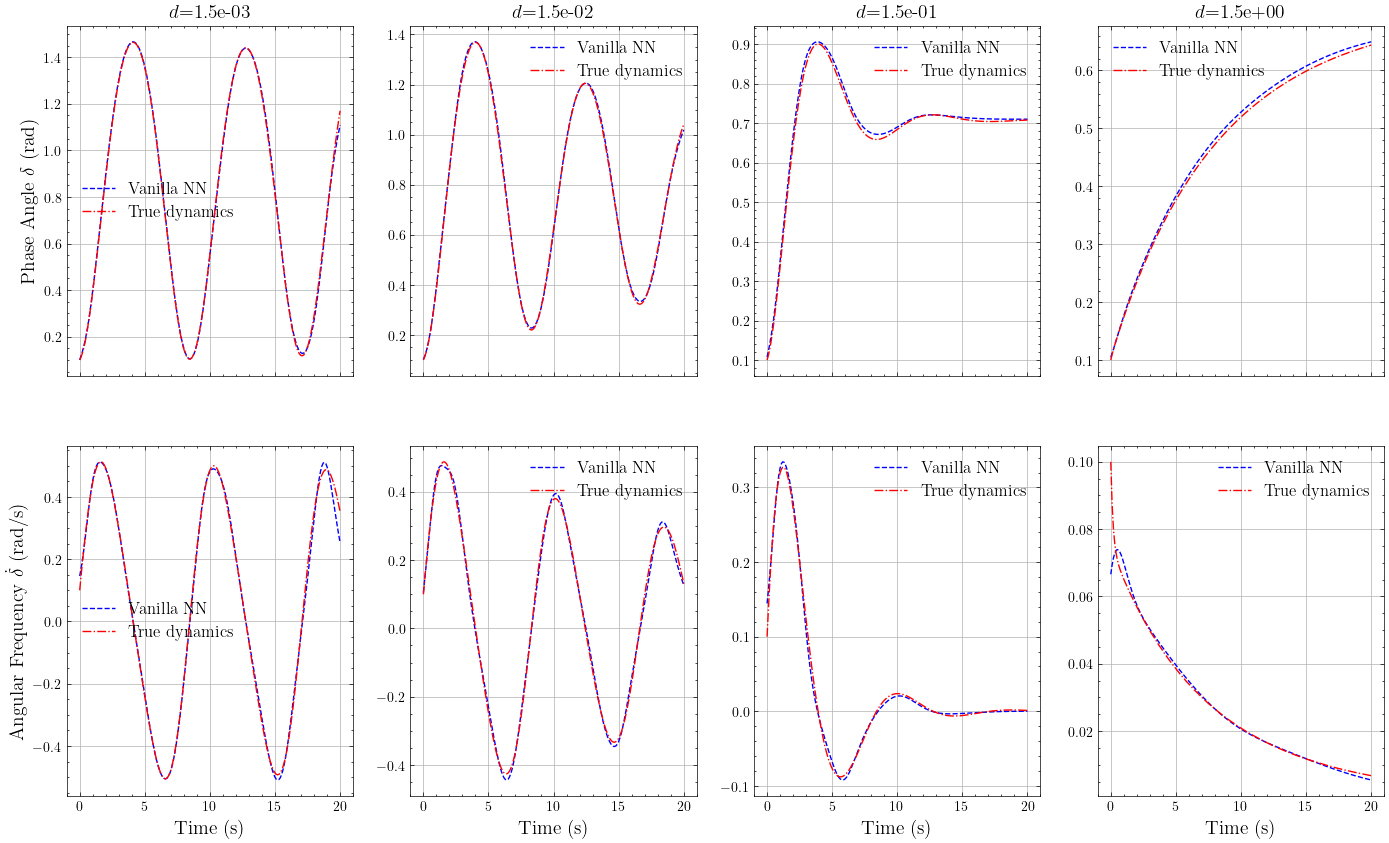

In [ ]:
abs_errors_nn = []
rel_errors_nn = []
 
fig, ax = plt.subplots(2, len(PARAM_LIST), figsize=(17, 10), sharex=True)

for index, param in enumerate(PARAM_LIST):

    solution, _, times = swing_ODEs_solver(
        initial_time=0,
        initial_state=INITIAL_STATE.detach().numpy(),
        final_time=20.0,
        timestep=0.1,
        inertia=0.25,
        damping=param,
        mechanical_power=0.13,
        voltage_magnitude=1.0,
        include_controllers=False,
        voltages=np.array([1.0]),
        phase_angles=np.array([0.0]),
        susceptances=np.array([0.2]),
        file_name="test_run",
        save_output_to_file=False,
        controller_proportional=0.05,
        controller_integral=0.1,
    )

    times = torch.tensor(
        data=times.astype(np.float32)[:,None], requires_grad=True
    ).to(device=DEVICE)

    phase_angle_labels = torch.tensor(
        data=solution[0,:].astype(np.float32)[:, None]
    ).to(device=DEVICE)

    angular_frequency_labels = torch.tensor(
        data=solution[1,:].astype(np.float32)[:, None]
    ).to(device=DEVICE)

    phase_angle_pred = vanilla_nns[index].forward(data=times, initial_state=INITIAL_STATE)

    angular_frequency_pred = torch.autograd.grad(
        outputs=phase_angle_pred,
        inputs=times,
        grad_outputs=torch.ones_like(phase_angle_pred),
        create_graph=True,
        retain_graph=True,
    )[0]

    pred_vector = torch.stack(tensors=(phase_angle_pred, angular_frequency_pred), dim=0)
    label_vector = torch.stack(tensors=(phase_angle_labels, angular_frequency_labels), dim=0)

    l2_abs, l2_rel = l2_error(pred=pred_vector, ground_truth=label_vector)

    print(f"L2 absolute error: {l2_abs:.2e}")
    print(f"L2 relative error: {l2_rel:.2e}")

    abs_errors_nn.append(l2_abs)
    rel_errors_nn.append(l2_rel)

    ax[0, index].plot(times.detach().numpy(), phase_angle_pred.detach().numpy(), color='blue', linestyle='--', label='Vanilla NN')
    ax[0, index].plot(times.detach().numpy(), solution[0, :], color="red", linestyle="-.", label="True dynamics")
    ax[0, index].grid()
    ax[0, index].legend(fontsize=12, loc="best")
    ax[0, index].set_title(f'${VARYING_PARAM_NOTATION}$='+f"{param:.1e}", fontsize=14)

    ax[1, index].plot(times.detach().numpy(), angular_frequency_pred.detach().numpy(), color='blue', linestyle='--', label='Vanilla NN')
    ax[1, index].plot(times.detach().numpy(), solution[1, :], color="red", linestyle="-.", label="True dynamics")
    ax[1, index].grid()
    ax[1, index].legend(fontsize=12, loc="best")
    ax[1, index].set_xlabel("Time (s)", fontsize=14)

    if index == 0:
        ax[0, index].set_ylabel("Phase Angle $\delta$ (rad)", fontsize=14)
        ax[1, index].set_ylabel("Angular Frequency $\dot{\delta}$ (rad/s)", fontsize=14)


exact_vs_pred_image: str = f"vanilla_nn/{VARYING_PARAM}_pinn_vs_ground_truth_seed_{SEED}.pdf"

if SAVE:
    print("Saving...")
    plt.savefig(fname=PATH_TO_IM_DIR+exact_vs_pred_image, format="pdf", bbox_inches="tight")

plt.show()

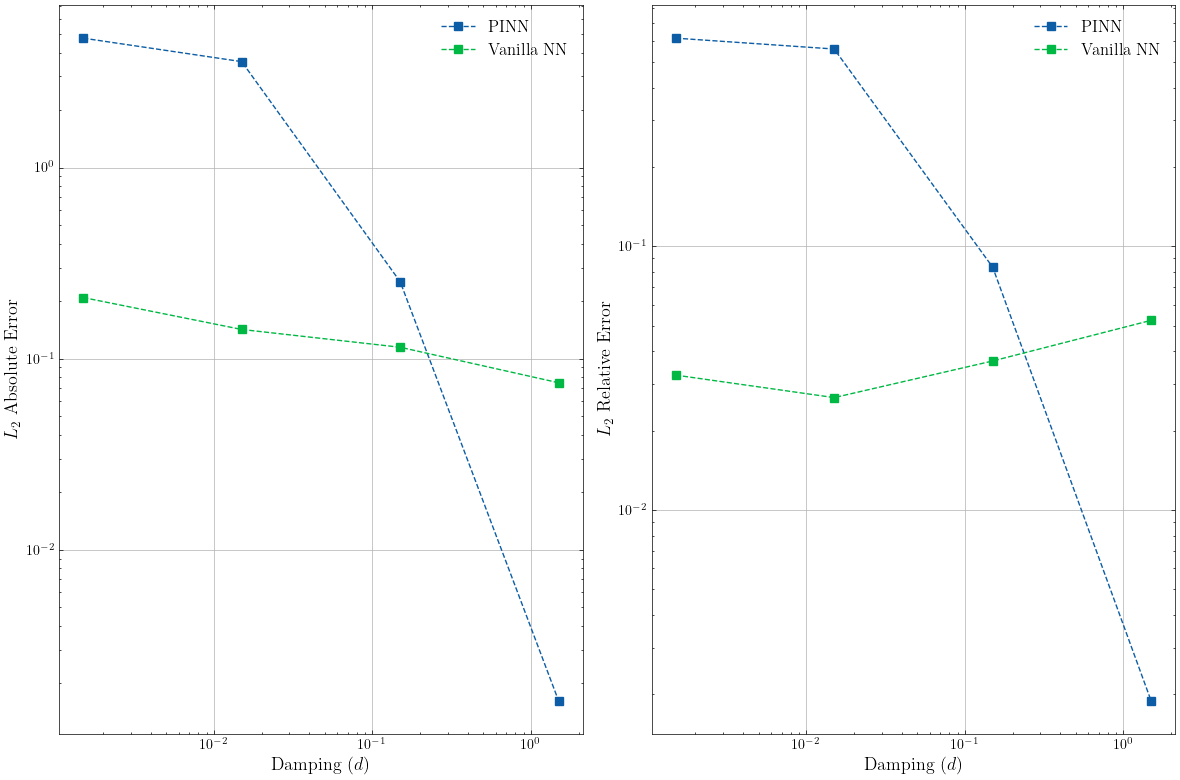

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharex=True)

ax[0].loglog(PARAM_LIST, [ls.detach().numpy() for ls in abs_errors_pinns], marker='s', linestyle='--', label="PINN")    
ax[0].loglog(PARAM_LIST, [ls.detach().numpy() for ls in abs_errors_nn], marker='s', linestyle='--', label="Vanilla NN")
ax[0].set_xlabel(f"{VARYING_PARAM.title()} (${VARYING_PARAM_NOTATION}$)", fontsize=13)
ax[0].set_ylabel("$L_{2}$ Absolute Error", fontsize=13)
ax[0].legend(fontsize=12)
ax[0].grid()

ax[1].loglog(PARAM_LIST, [ls.detach().numpy() for ls in rel_errors_pinns], marker='s', linestyle='--', label="PINN")    
ax[1].loglog(PARAM_LIST, [ls.detach().numpy() for ls in rel_errors_nn], marker='s', linestyle='--', label="Vanilla NN")
ax[1].set_xlabel(f"{VARYING_PARAM.title()} (${VARYING_PARAM_NOTATION}$)", fontsize=13)
ax[1].set_ylabel("$L_{2}$ Relative Error", fontsize=13)
# ax[1].set_xticklabels()
ax[1].legend(fontsize=12)
ax[1].grid()

plt.subplots_adjust(left=0.1, right=0.9, hspace=-0.7)
plt.tight_layout()

test_error: str = f"{VARYING_PARAM}_l2_test_error_random_seed_{SEED}.pdf"

if SAVE:
    print("Saving...")
    plt.savefig(fname=PATH_TO_IM_DIR+test_error, format="pdf", bbox_inches="tight")
